# Importing the Libraries We Will Need

In [1]:
# Selenium Imports
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common import TimeoutException
from selenium.common import NoSuchElementException

# Other Imports
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import re

# Preliminaries

## Utility Functions

In [2]:
# Rest and Long Rest Functions
def r(low = 4, high = 8):
    time.sleep(np.random.uniform(low, high))
    
def lr():
    r(10, 13)

In [3]:
def write(box, text, enter = True):
    for char in text:
        box.send_keys(char)
        time.sleep(np.random.uniform(0.1, 0.5))
    if enter:
        box.send_keys(Keys.ENTER)

## Prepping the Web Scraper

You can either use the code below to scrape the data, or you can use the xlsx file.

If `scrape_data` is `True`, it is assumed that you want to scrape the data.

In [4]:
scrape_data = False

In [5]:
# Setting User Agent Header as well as other Request Headers  
# This can be retrieved from http://httpbin.org/anything  <-
if scrape_data:
    headers = {
        
}

The code below creates a function that creates a ModHeader URL.

In [6]:
def create_header_url(headers):
    prefix = "https://webdriver.modheader.com/add?"
    for name in headers:
        prefix += name + "=" + headers[name] +"&"
    # Remove the final &
    prefix = prefix[:-1]
    # Replace spaces with %20
    prefix = prefix.replace(" ", "%20")
    return prefix

Add ModHeader as an extension

In [7]:
# To download the extension and find more info: https://modheader.com/docs/advanced/selenium-webdriver  
# File should be in the same directory as this notebook
if scrape_data:
    op = webdriver.ChromeOptions()
    op.add_extension("modheader.crx")

In [8]:
# Path to Chromedriver
# Downloads : https://chromedriver.chromium.org/downloads
# If you have 116 : https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/116.0.5845.96/win64/chromedriver-win64.zip
# File should be in the same directory as this notebook
if scrape_data:
    CHROME = "chromedriver.exe"

## Tests

In [9]:
# Are the headers working?
if scrape_data:
    s = Service(executable_path = CHROME)
    browser = webdriver.Chrome(service = s, options = op)
    browser.set_window_size(1750, 1000)
    browser.get(create_header_url(headers))
    r()
    browser.get("https://www.whatismybrowser.com/detect/what-http-headers-is-my-browser-sending")
    time.sleep(10)
    browser.close()

# Scraping the Nutritional Info

In [10]:
columns = ["product_name", "category", "subcategory", "size",
           "calories", "total fat", "saturated fat", "trans fat",
           "cholesterol", "sodium", "total carbs", "dietary fiber",
           "total sugars", "added sugars", "protein"]

In [11]:
mcdonalds = pd.DataFrame(columns = columns)

## Utility Functions

In [12]:
def does_el_exist(xpath):
    try:
        browser.find_element(By.XPATH, xpath)
    except NoSuchElementException:
        return False
    return True

## Scraping McDonald's Data

In [13]:
# Navigate to McDonalds Menu Site
if scrape_data:
    s = Service(executable_path = CHROME)
    browser = webdriver.Chrome(service = s, options = op)
    browser.set_window_size(1750, 1000)
    browser.get(create_header_url(headers))
    r()
    browser.get("https://www.mcdonalds.com/us/en-us/full-menu.html")
    r()

In [14]:
# Scrape Data
if scrape_data:
    # Doesn't scrap the $1$2$3 Dollar Menu, which only has duplicate menu items from previous categories
    for i in range(1, 10):
        # Click Category Card (i.e. Burgers, Beverages, etc)
        category_card_xp = f'//*[@id="container-65cdd10604"]/div/div/nav/ul[2]/li[{i}]'
        category_card = browser.find_element(By.XPATH, category_card_xp)
        category_card.click()
        lr()
        
        # Get HTML code for current page -> page with all products of the current category
        soup = BeautifulSoup(browser.page_source, "lxml")
        
        # Find name of category
        category_name = soup.find("h1").text

        # Find number of products in category
        num_products = len(soup.find_all("li", attrs={"class": "cmp-category__item"}))

        # Save the URL of this category, so that we can come back to it later.
        category_url = browser.current_url
        
        # For product in category
        for j in range(1, num_products + 1):
            # Select a product
            product_xp = f'//*[@id="maincatcontent"]/div[3]/ul/li[{j}]/a/div/div'
            product    = browser.find_element(By.XPATH, product_xp)
            product.click()
            lr()
            
            # Some products have multiple sizes ("Small", "Medium", etc)
            # Does the optional size selector exist?
            optional_size_xp = '//*[@id="container-20012ecdca"]/div/div[1]/div/div[1]/div/div[1]/div[2]/ul'
            if does_el_exist(optional_size_xp): # YES
                size_selector_exists = True
                
                # Find the size selector and save all of the options
                ## Find Selector
                optional_size_selector = browser.find_element(By.XPATH, optional_size_xp) 
                ## Save the Options
                soup = BeautifulSoup(browser.page_source, "lxml")
                ### t for temp
                t = soup.find("ul", attrs={"class": "cmp-product-details-main__variations-sizes"})
                t = t.find_all("span", attrs={"class": "cmp-product-details-main__variations-size-title"})
                options = [option.text.strip()   for option in t]
                
                # Save the URLs to each size
                ## Re-find selector to avoid stale reference exception
                optional_size_selector = browser.find_element(By.XPATH, optional_size_xp) 
                ## Find the list of optional size buttons
                t = optional_size_selector.find_elements(By.TAG_NAME, "li")
                optional_size_buttons = [button.find_element(By.TAG_NAME, "a")   for button in t]
                ## Find the link for each button
                urls = [size.get_property("href")   for size in optional_size_buttons ]
                
                ## Save the number of subproducts inside of this product 
                # (i.e. for a drink with 3 sizes, this would be 3. For a sandwich with no sizes, this would be 1)
                num_subproducts = len(options)
                lr()
            else: # NO
                num_subproducts = 1
                size_selector_exists = False

            # Extract Nutritional Information
            while(num_subproducts != 0):
                # This is where we will save all of the nutritional information for the current (sub)product
                curr_prod_nutr_info = {}
                
                # Save Category Name, which we already found previously
                curr_prod_nutr_info["category"] = category_name
                
                # If there are more than one subproducts, navigate to the appropriate subproduct's url
                #    and save the option/size name
                if size_selector_exists:
                    browser.get(urls[-num_subproducts])
                    lr()
                    curr_prod_nutr_info["size"] = options[-num_subproducts]

                # Click the "Nutritional Facts" drop down button
                browser.find_element(By.XPATH, '//*[@id="accordion-c921f9207b-item-842cb18782-button"]').click()
                r()
                
                # Get the HTML for the current page
                soup = BeautifulSoup(browser.page_source, "lxml")
                
                # Extract Product Name
                curr_prod_nutr_info["product_name"] = soup.find("h1").text.strip()
                
                # Extract Primary Info: Calories   Total Fat    Total Carbs   Protein
                t = soup.find("div", attrs = {"class": "primarynutritions aem-GridColumn aem-GridColumn--default--12"})
                primary_nutr_list = t.div.ul
                for item, label in zip(primary_nutr_list.find_all("li"), ["calories", "total fat", "total carbs", "protein"]):
                    value = item.span.span.text
                    value = re.search(r"[.0-9]+", value).group()
                    curr_prod_nutr_info[label] = value


                # Extract Secondary Info
                t = soup.find("div", attrs = {"class": "secondarynutritions aem-GridColumn--default--none aem-GridColumn aem-GridColumn--default--12 aem-GridColumn--offset--default--0"})
                sec_nutr_list = t.find("ul")
                for item in sec_nutr_list.find_all("li"):
                    metric = item.find("span", attrs = {"class", "metric"})
                    metric = metric.text[: -1].lower()
                    if metric in columns:
                        value = item.find("span", attrs = {"class": "value"})
                        value = re.search(r"[.0-9]+", value.text).group()
                        curr_prod_nutr_info[metric] = value

                # Add Nutrition of current product
                mcdonalds.loc[len(mcdonalds)] = curr_prod_nutr_info
                
                # Update the number of subproducts that we have left to check
                num_subproducts -= 1
                
                # Long Rest before moving on
                lr()
                
            # Navigate back to category page
            browser.get(category_url)
            
            # Long Rest before moving on
            lr()


In [15]:
if scrape_data:
    mcdonalds.to_excel("mcdonalds_original.xlsx", index = False)
else:
    mcdonalds = pd.read_excel("mcdonalds_original.xlsx")

In [16]:
if scrape_data:
    browser.close()

# Clean Data

In [17]:
# Drop Duplicates, where the only difference is category
cols = list(mcdonalds.columns)
cols.remove("category")
mcdonalds.drop_duplicates(subset = cols, keep = "first", inplace = True)

In [18]:
# Make all appropriate columns of the float type
for col in mcdonalds.columns[4:]:
    mcdonalds.loc[:, col] = mcdonalds[col].astype(float)

In [19]:
# Drop Subcategory column
mcdonalds = mcdonalds.drop(["subcategory"], axis = 1)

In [20]:
# We will remove menu items from the following categories
# * Happy Meal - This project is based off of adult estimates (2,000 calories per day)
mcdonalds = mcdonalds[~ np.isin(mcdonalds.category, ["Happy Meal®"])]

In [21]:
# We will remove the following menu items, as they are implied to be for children only
for prod in ["Honest Kids® Appley Ever After® Organic Juice Drink", "1% Low Fat Milk Jug", 
             "Reduced Sugar* Low Fat Chocolate Milk Jug"]:
    mcdonalds = mcdonalds[mcdonalds.product_name != prod]

In [22]:
# Remove any products where the size = "Kids"
cond = mcdonalds["size"] == "Kids"
mcdonalds = mcdonalds[~cond]

In [23]:
# Remove all the sauces and packets and honey.
cond1 = mcdonalds.product_name.str.endswith("Sauce")
cond2 = mcdonalds.product_name.str.endswith("Packet")
cond3 = mcdonalds.product_name == "Honey"
cond = cond1 | cond2 | cond3
mcdonalds = mcdonalds[~ cond]

In [24]:
# The following category names are renamed
#   McCafé® Coffees      to McCafe Coffees
#   McNuggets® and Meals to McNuggets and Meals
mcdonalds.loc[np.isin(mcdonalds.category, ["McCafé® Coffees"]), "category"] = "McCafe Coffees"
mcdonalds.loc[np.isin(mcdonalds.category, ["McNuggets® and Meals"]), "category"] = "McNuggets and Meals"

In [25]:
# Final Product
mcdonalds

product_name   category    size  calories  \
0         Bacon, Egg  & Cheese Biscuit  Breakfast     NaN     460.0   
1                        Egg McMuffin®  Breakfast     NaN     310.0   
2                    Sausage McMuffin®  Breakfast     NaN     400.0   
3           Sausage McMuffin® with Egg  Breakfast     NaN     480.0   
4                      Sausage Biscuit  Breakfast     NaN     460.0   
..                                 ...        ...     ...       ...   
193  Minute Maid® Premium Orange Juice  Beverages   Large     270.0   
197                      Hot Chocolate  Beverages   Small     370.0   
198              McCafé® Hot Chocolate  Beverages  Medium     450.0   
199              McCafé® Hot Chocolate  Beverages   Large     560.0   
200                      DASANI® Water  Beverages     NaN       0.0   

     total fat  saturated fat  trans fat  cholesterol  sodium  total carbs  \
0         26.0           13.0        0.0        215.0  1330.0         39.0   
1         13.0            6.0        0.0        250.0   770.0         30.0   
2         26.0           10.0        0.5         55.0   760.0         29.0   
3         31.0           12.0        0.5        280.0   830.0         30.0   
4         30.0           13.0        0.0         35.0  1090.0         37.0   
..         ...            ...        ...          ...     ...          ...   
193        0.0            0.0        0.0          0.0    65.0         65.0   
197       13.0            8.0        0.0         45.0   180.0         54.0   
198       15.0            9.0        0.5         55.0   220.0         66.0   
199       20.0           12.0        0.5         60.0   260.0         76.0   
200        0.0            0.0        0.0          0.0     0.0          0.0   

     dietary fiber  total sugars  added sugars  protein  
0              2.0           3.0           1.0     17.0  
1              2.0           3.0           1.0     17.0  
2              2.0           2.0           1.0     14.0  
3              2.0           2.0           1.0     20.0  
4              2.0           2.0           1.0     11.0  
..             ...           ...           ...      ...  
193            1.0          58.0           0.0      4.0  
197            1.0          47.0          32.0     11.0  
198            1.0          58.0          39.0     14.0  
199            2.0          71.0           3.0     17.0  
200            0.0           0.0           0.0      0.0  

[180 rows x 14 columns]

In [26]:
mcdonalds.category.value_counts()

McCafe Coffees               60
Beverages                    56
Breakfast                    24
Sweets & Treats              16
Burgers                       9
Chicken & Fish Sandwiches     6
McNuggets and Meals           5
Fries & Sides                 4
Name: category, dtype: int64

# Results

## Constants and Utility Functions

[Here are the Daily Values (DVs) recommended by the Food and Drug Administration (FDA).](https://www.fda.gov/food/new-nutrition-facts-label/daily-value-new-nutrition-and-supplement-facts-labels) 

These are based off of a 2,000 calorie diet.

The FDA does not give any recommendations for trans fat. [This is because it is recommended that Americans should select foods with no trans fat whenever possible;](https://medlineplus.gov/ency/patientinstructions/000786.htm) [no amount is considered safe.](https://ncdalliance.org/why-ncds/risk-factors-prevention/trans-fats-elimination) 

We will use the World Health Organization's 2018 limit of [2.2 grams per day.](https://www.who.int/news/item/09-09-2020-more-than-3-billion-people-protected-from-harmful-trans-fat-in-their-food), keeping in mind that the value of trans fats should, ideally, be as close to 0 as possible. 

The FDA also does not provide a daily limit for "total sugars."

In [36]:
limits = {
    "calories": 2000,
    "total fat": 78,
    "saturated fat": 20,
    "trans fat": 2.2,
    "cholesterol": 300, 
    "sodium": 2300,
    "total carbs": 275,
    "dietary fiber": 28,
    "total sugars": np.nan,
    "added sugars": 50, 
    "protein": 50
}

In addition, note that while the FDA recommends a maximum of 50 grams of added sugar, it is well known that we should try to limit our intake of sugar as much as possible. The American Heart Association (AHA) has more strict recommendations for sugar, [stating that men should have a maximum of 36 grams of sugar and women should have a maximum of 25 grams.](https://www.heart.org/en/healthy-living/healthy-eating/eat-smart/sugar/how-much-sugar-is-too-much) While we will stick with the FDA limitations for consistency, we will keep the AHA recommendations in mind when analyzing the sugar content of menu items.

Let's save a list of all the nutrient names.

In [197]:
nutrient_names = list(limits.keys())

Let's also create a colormap.

Assuming that a given menu item is being eaten as part of one of three meals for the day, we'd expect the menu item to take up around 33% or less of the daily value (DV) measurement for each nutrient.

Thus, if the DV is less than or equal to 33%, the value will be green. As the DV becomes larger than 33%, it becomes more orange and, eventually, more red.

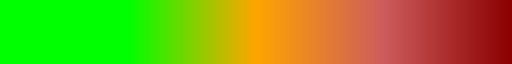

In [198]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

cmap1 = LinearSegmentedColormap.from_list("cmap1", ["lime", "lime", "orange", "indianred", "darkred"])
cmap1

In [199]:
# Font help from here:
# https://github.com/olgabot/sciencemeetproductivity.tumblr.com/blob/master/posts/2012/11/how-to-set-helvetica-as-the-default-sans-serif-font-in.md

from matplotlib.patches import Rectangle
def create_nutritional_label(limits, values, category, title_size = 22, save = False):
    # The Daily Value is calculated using the true value of the nutrition category and dividing it by the limit
    #    and multiplying by 100
    # For example, for a food that takes up 500 calories in a 2,000 calorie diet, the food takes up
    #    500 / 2000 * 100 = 25% of the daily calorie allowance.
    #    DV = 25%
    DV = dict(zip(nutrient_names, 
                  np.array(np.round(np.array(values) / np.array(limits) *100, 0), dtype = int)))
    
    # Create a dictionary that has each nutrition label category as the key and the (rounded) Daily Value Limits 
    #    as a value
    limits = dict(zip(nutrient_names, np.round(limits, 2)))
    
    # Create a dictionary that has each nutrition label category as the key and the (rounded) true value value from a
    #   menu item
    values = dict(zip(nutrient_names, np.round(values, 2)))
    
    # Define the fig and ax; Set the x and y axis limits; remove all tick marks and labels
    fig, ax = plt.subplots(figsize = (5, 6.5))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    
    # Add the Nutrition Facts Title and the line underneath it
    ax.text(1.25, 9.1, "Nutrition Facts", fontdict = {"size": 30, "family": "Franklin Gothic Heavy"})
    ax.plot([0.25, 9.75], [8.9, 8.9], color = "black", linewidth = 0.5)
    
    # Add the Category Title and the bar underneath it
    ax.text(5.1, 8.2, ("Med. "+ category).center(26), fontdict = {"size": title_size, "family": "Franklin Gothic Medium"},
           ha = "center")
    ax.add_patch(Rectangle((0.25, 7.75), 9.5, 0.20, color = "black"))


    # Add Calories value,  title, DV, color, and bar underneath
    ## Value
    ax.text(9.75, 7, values["calories"], fontdict = {"size": 25, "family": "Franklin Gothic Heavy"},
           ha = "right")
    ## Title
    ax.text(0.25, 6.6, "Calories", fontdict = {"size": 40, "family": "Franklin Gothic Heavy"},
           ha = "left")
    ## DV and Color
    perc = np.round(DV["calories"])
    color_ind = (DV["calories"] / 100)
    color_ind = np.clip(0, 1, color_ind)
    txt = ax.text(9.75, 6.6,  f"{perc}% DV", fontdict = {"size": 15, "family": "Franklin Gothic Heavy"},
           ha = "right", color = cmap1(color_ind))
    ## Add bar underneath Calories 
    ax.add_patch(Rectangle((0.25, 6.3), 9.5, 0.15, color = "black"))

    
    # Add "% Daily Value" label and line underneath
    ax.text(9.75, 5.85,  "% Daily Value", fontdict = {"size": 15, "family": "Franklin Gothic Heavy"},
           ha = "right")
    ax.plot([0.25, 9.75], [5.7]*2, color = "black", linewidth = 0.5)

    # Define an x and y position
    x = 0.25
    y = 5.3
    
    # Define an offset that will be used to offset the x position of the category values from the category titles
    offset = ["", 2.4, 4.1, 3.1, 3.2, 2.15, 3.1, 3.9, 3.8, 4.35, 2.05]
    
    # Plot the remaining category value, title, DV, color and bars
    for ind, label in enumerate(DV):
        if label in ["calories"]:
            continue
        
        ## Plot the label / title first
        if label not in ["saturated fat", "trans fat", "dietary fiber", "total sugars", "added sugars"]:
            ax.text(x, y, label.title(), fontdict = {"size": 15, "family": "Franklin Gothic Heavy"}, 
                    ha = "left")
        else:
            # If the label is saturated fat, trans fat, or total sugars, indent the label (add x offset)
            if label != "added sugars":
                ax.text(x+0.75, y, label.title(), fontdict = {"size": 15, "family": "Franklin Gothic Medium"}, 
                    ha = "left")
            # If the label is added sugars, indent the label even more.
            # Also add the values
            else:
                ax.text(x+1.25, y, "Includes " + str(values[label]) +"g" +" "+ label.title(), 
                        fontdict = {"size": 15, "family": "Franklin Gothic Medium"}, ha = "left")

        # Define the units used to measure this particular nutrition categoy
        units = "g" if label not in  ["sodium", "cholesterol"] else "mg"  

        # Plot the values for each category except added sugars, which has already been plotted.
        if label != "added sugars":
            ax.text(x + offset[ind] , y, 
                    str(values[label])+" " + units, 
                    fontdict = {"size": 15, "family": "Franklin Gothic Medium"}, 
                    ha = "left")
        
        # Plot the DV as the correct color
        color_ind = (DV[label] / 100)
        color_ind = np.clip(0, 1, color_ind)
        if label != "total sugars":
            ax.text(x + 9.6, y, str(DV[label])+"%", fontdict = {"size": 15, "family": "Franklin Gothic Heavy"}, 
                    ha = "right", color = cmap1(color_ind))

        # Plot the line underneath the category
        ax.plot([0.25, 9.85], [y-0.1]*2, color = "black", linewidth = 0.5)
        
        # Decrement the y coordinate.
        y-=0.5
    
    if save:
        fig.savefig("fig")
    plt.show()

In [200]:
# A quick way to use the above function
def quick_label(category, title_size = 22, save = False):
    # Create a df with the nutrition information of only products of a given category
    df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"]
    
    # Find the mean of each column and extract the values as a numpy array
    values = round(df.median(), 2).values
    
    #limits needs to be in the form of an array. Take the values of the limits dictionary, convert them to a list, then
    #   a numpy array
    create_nutritional_label(np.array(list(limits.values())), values, category, title_size, save)

In [201]:
# Show the distribution of nutrient values for each menu item in a certain category
def show_distribution(category, title, df = None, bins = 10, save = False):
    if df is None:
        # Choose only menu items in a certain category
        cond = mcdonalds["category"] == category
        df = mcdonalds[cond]

    fig, axes = plt.subplots(2, 5, figsize = (13, 6), dpi = 300)
    axes = axes.ravel()
    
    # Create the limits dictionary minus the "total sugars" entry
    limits_wo_total_sugars = limits.copy()
    del limits_wo_total_sugars["total sugars"]
    
    for ind, value in enumerate(limits_wo_total_sugars):
        # Create a histogram with a certain number bins
        bars = axes[ind].hist(df[value], bins = bins)
        
        # Draw a line indicating where 1/3 of the daily value is (33% DV)
        limit = limits_wo_total_sugars[value] / 3
        axes[ind].plot([limit, limit], [0, max(bars[0])], color = "red")
        
        # Add title and y label, based on conditions
        axes[ind].set_title(value)
        if ind in [0, 5]:
            axes[ind].set_ylabel("Frequency", fontsize = 12)
        
    fig.tight_layout()
    suptitle = fig.suptitle("Distribution of Nutrient Values for " + title, y = 1.05, fontsize = 18)
    
    if save:
        fig.savefig('fig', dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[suptitle])
    plt.show()

Now, we are ready to visualize our results.

# Results

## Breakfast

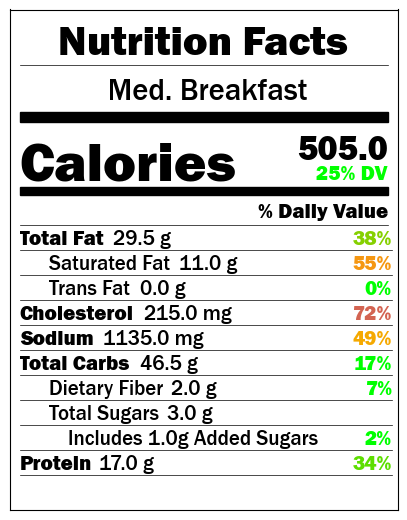

In [202]:
category = "Breakfast"
quick_label(category)

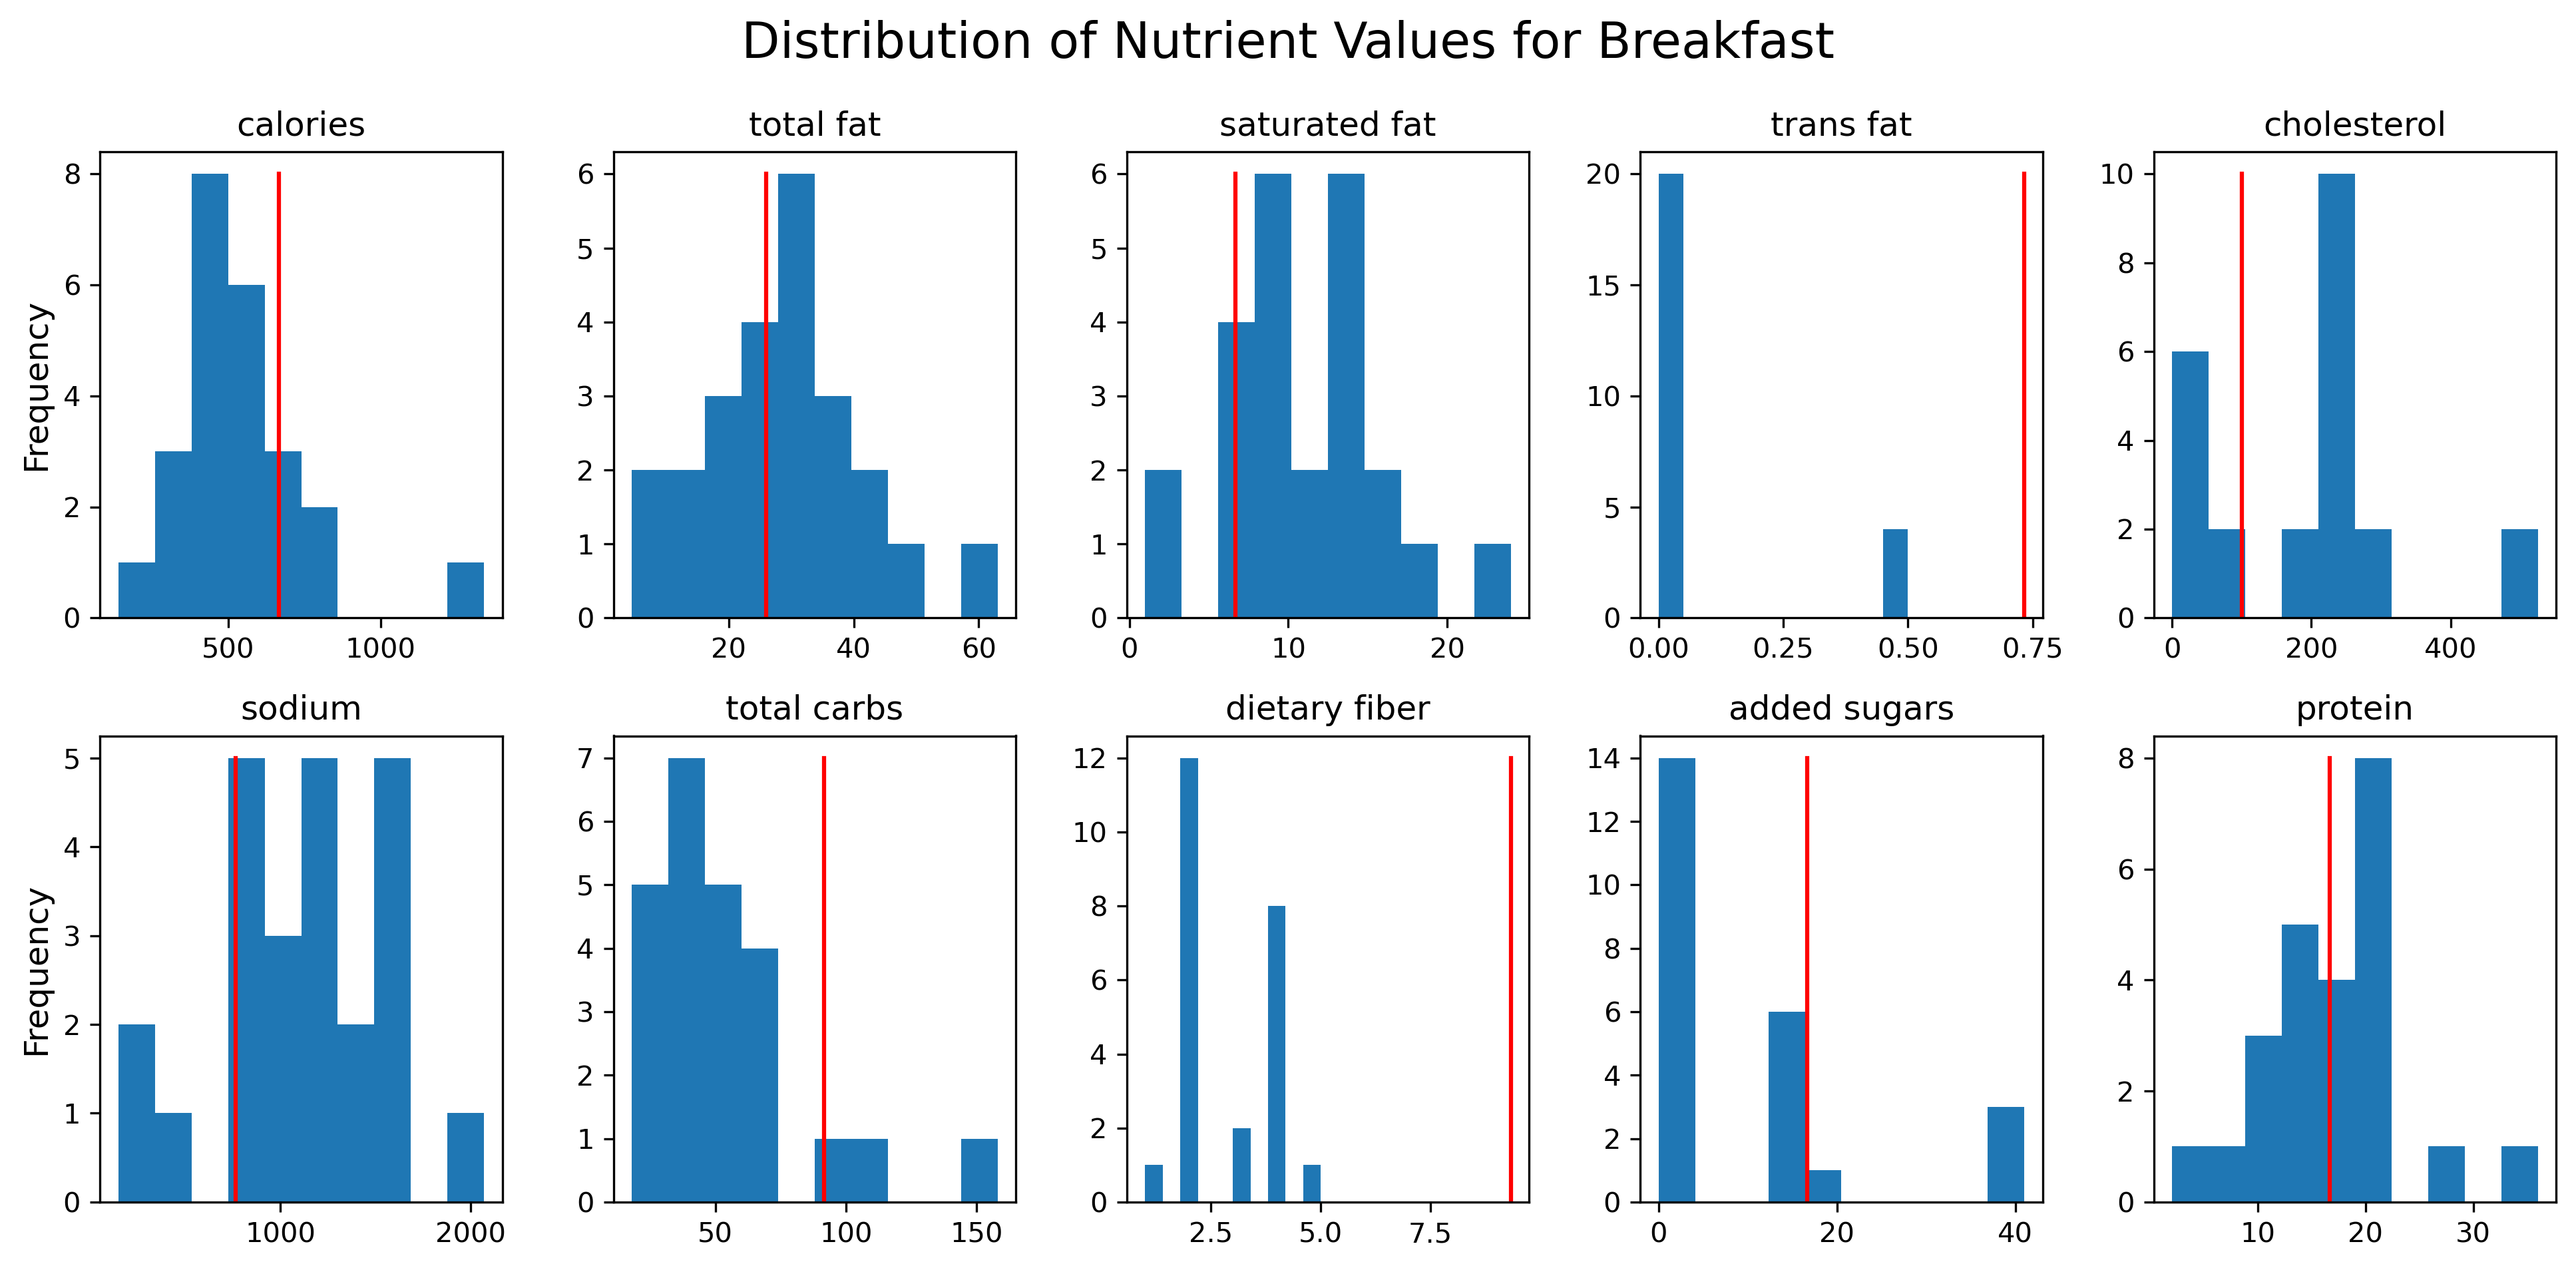

In [203]:
show_distribution(category, category)

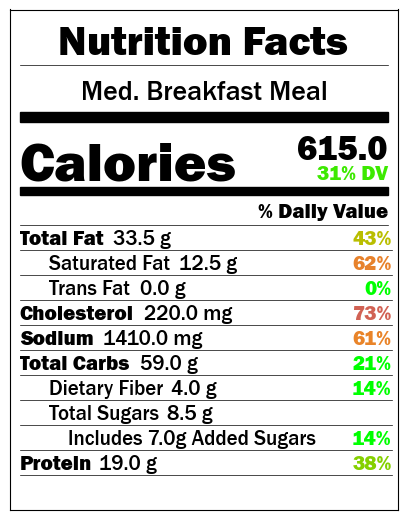

In [204]:
# All Breakfast items that consist of more than a single sandwich, order of hashbrowns, and bowl of oatmeal
# Makes up half of the menu

cond = (mcdonalds.category == "Breakfast") & \
               (mcdonalds.product_name.str.endswith(" Meal") | 
                np.isin(mcdonalds.product_name, ["Big Breakfast®", "Big Breakfast® with Hotcakes", 
                                                 "Hotcakes", "Hotcakes and Sausage"]))
median_values = mcdonalds.loc[cond, "calories":"protein"].median().values

# Create the Nutritional Label
median_values = np.round(median_values, 2)
title = "Breakfast Meal"
create_nutritional_label(np.array(list(limits.values())), median_values, title, 20)

In [205]:
# How many items in the Breakfast category have a cholesterol less than 300 / 3 
# (or equivalently, has a DV for cholesterol less than 33%)
okay_chol = mcdonalds[(mcdonalds.category == "Breakfast") & (mcdonalds.cholesterol <= 300/3)]
len(okay_chol)

8

In [206]:
# How many items are in the Breakfast category in total?
len(mcdonalds[(mcdonalds.category == "Breakfast")]) 

24

In [207]:
# How many items in the Breakfast category have a cholesterol over the daily limit?
mcdonalds[(mcdonalds.category == "Breakfast") & (mcdonalds.cholesterol > 300)]

product_name   category size  calories  total fat  \
9                 Big Breakfast®  Breakfast  NaN     760.0       48.0   
10  Big Breakfast® with Hotcakes  Breakfast  NaN    1340.0       63.0   

    saturated fat  trans fat  cholesterol  sodium  total carbs  dietary fiber  \
9            18.0        0.0        485.0  1530.0         57.0            3.0   
10           24.0        0.5        525.0  2070.0        158.0            5.0   

    total sugars  added sugars  protein  
9            3.0           1.0     26.0  
10          48.0          41.0     36.0

In [208]:
# How many items in the breakfast category have DV for cholesterol, saturated fat, and sodium that is under 33%?
mcdonalds[(mcdonalds.category == "Breakfast") & 
          (mcdonalds.cholesterol <= limits["cholesterol"] / 3) & 
          (mcdonalds["saturated fat"] <= limits["saturated fat"] / 3) &
          (mcdonalds["sodium"] <= limits["sodium"] / 3)]

product_name   category size  calories  total fat  saturated fat  \
11               Hotcakes  Breakfast  NaN     580.0       15.0            6.0   
14            Hash Browns  Breakfast  NaN     140.0        8.0            1.0   
15  Fruit & Maple Oatmeal  Breakfast  NaN     320.0        4.5            1.5   

    trans fat  cholesterol  sodium  total carbs  dietary fiber  total sugars  \
11        0.0         40.0   530.0        101.0            2.0          45.0   
14        0.0          0.0   310.0         18.0            2.0           0.0   
15        0.0          5.0   150.0         64.0            4.0          31.0   

    added sugars  protein  
11          40.0      9.0  
14           0.0      2.0  
15          18.0      6.0

## Burgers

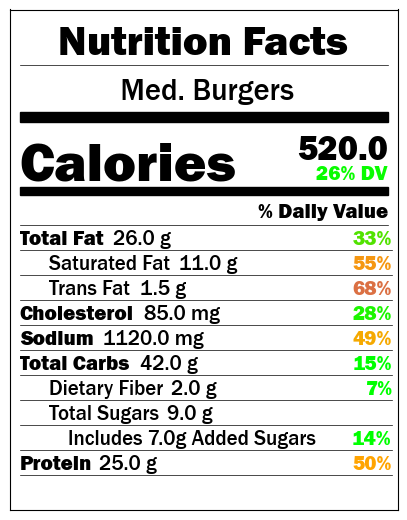

In [209]:
category = "Burgers"
quick_label(category)

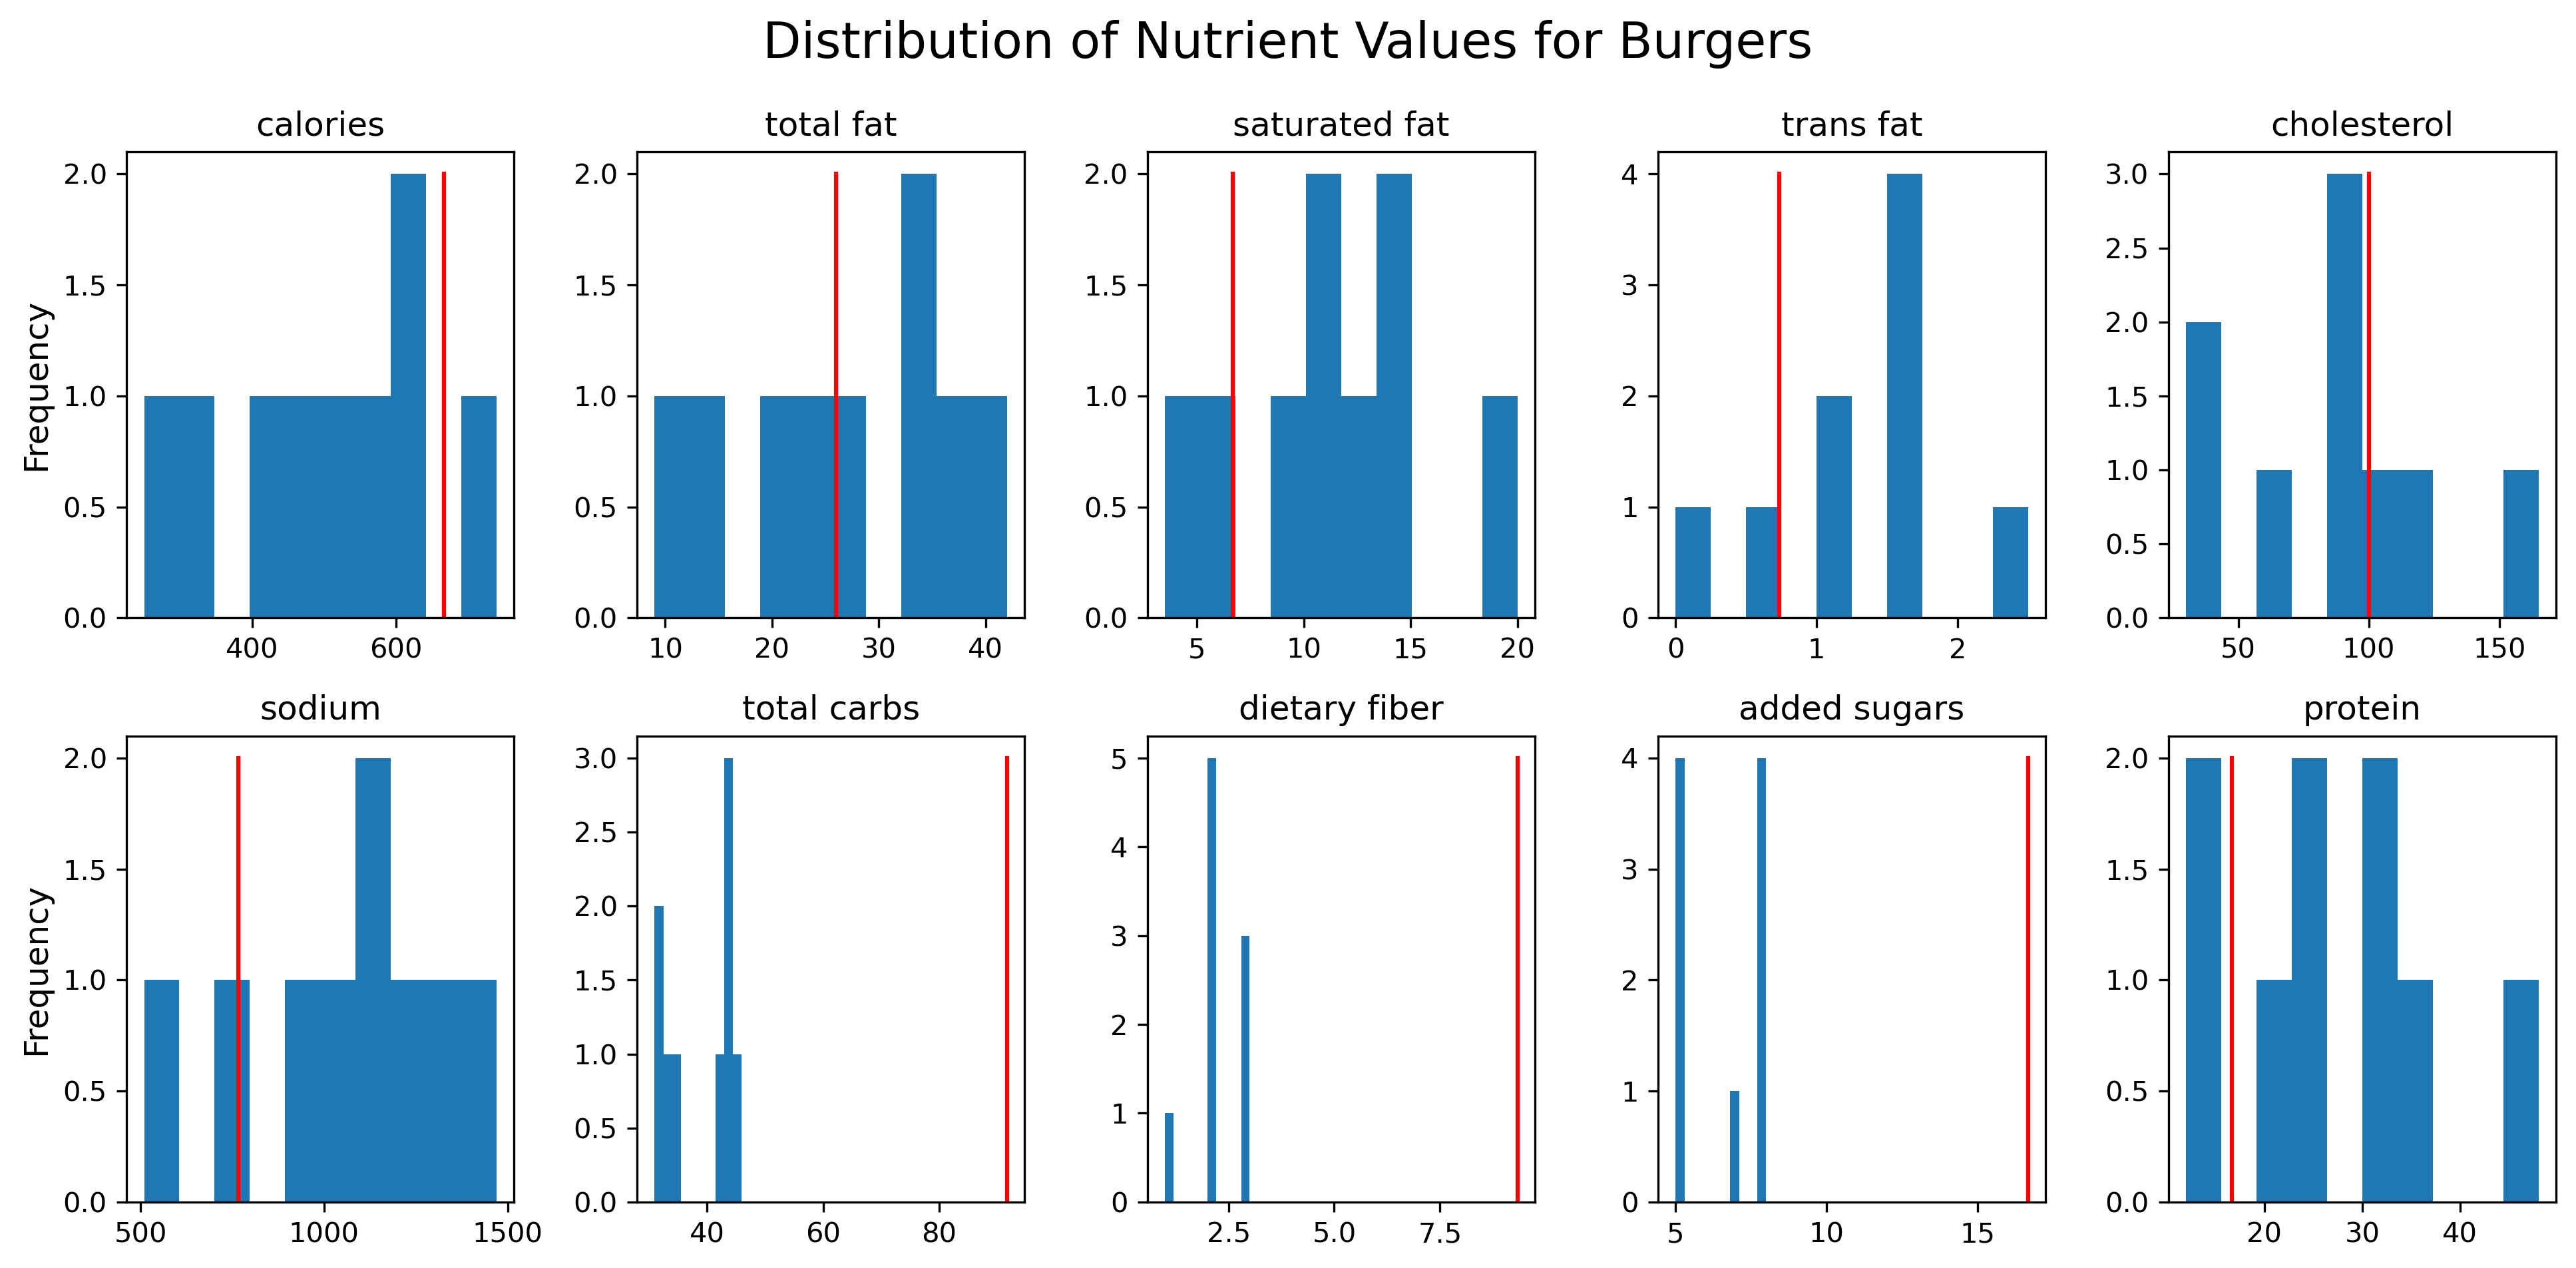

In [210]:
show_distribution(category, category)

### Median Burgers + Small Fries + Median Small Beverage

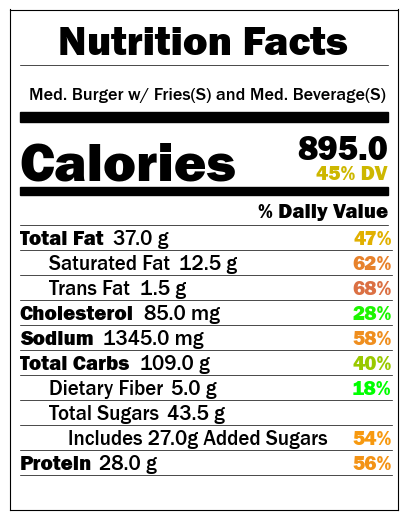

In [211]:
# Save the nutritional data for small fries
cond = (mcdonalds.product_name == "World Famous Fries®") & (mcdonalds["size"] == "Small")
small_fries = mcdonalds.loc[cond, "calories":"protein"].values[0]

# Save the nutritional data for median small drink
cond = (mcdonalds.category == "Beverages") & (mcdonalds["size"] == "Small")
small_drink = mcdonalds.loc[cond, "calories":"protein"].median().values

# Add the values of a small fry and median small beverage to the df
category = "Burgers"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += small_fries + small_drink

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "Burger w/ Fries(S) and Med. Beverage(S)"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 13)

### Median Burgers + Small Fries + Median Small Shake

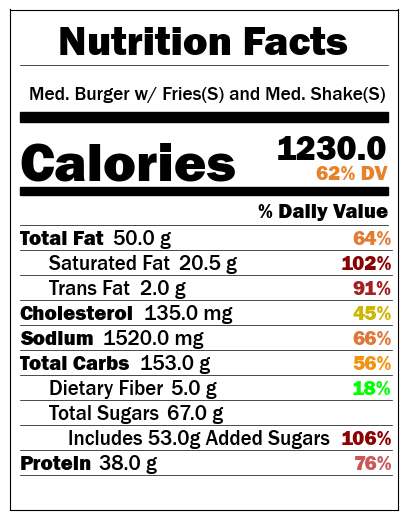

In [212]:
# median Small Shake
cond = (mcdonalds.category == "Sweets & Treats") & (mcdonalds.product_name.str.endswith("Shake")) & (mcdonalds["size"] == "Small")
small_shake = np.round(mcdonalds.loc[cond, "calories":"protein"].median().values, 2)

# Add small fry and median small shake values to df
category = "Burgers"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += small_fries + small_shake

# Create nutritional label
median_values = round(df.median(), 2).values
title = "Burger w/ Fries(S) and Med. Shake(S)"
create_nutritional_label(np.array(list(limits.values())), median_values, title, 14)

### Median Burgers  + Median Small Shake

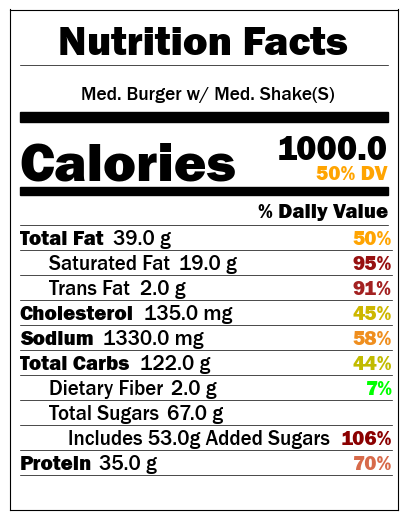

In [213]:
# Small Shake only
category = "Burgers"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += small_shake

# Create nutritional label
median_values = round(df.median(), 2).values
title = "Burger w/ Med. Shake(S)"
create_nutritional_label(np.array(list(limits.values())), median_values, title, 14)

### Median Burgers + Large Fries + Median Large Beverage

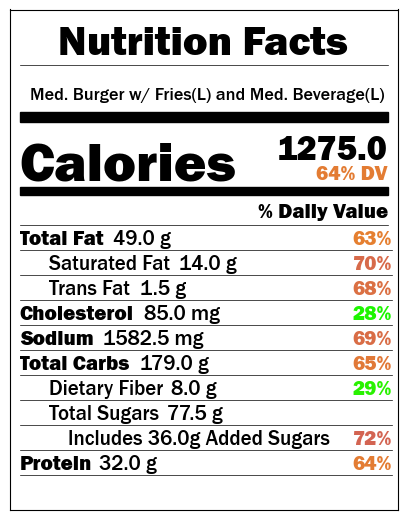

In [214]:
# Save the nutritional data for Large fries
cond = (mcdonalds.product_name == "World Famous Fries®") & (mcdonalds["size"] == "Large")
large_fries = mcdonalds.loc[cond, "calories":"protein"].values[0]

# Save the nutritional data for median Large drink
cond = (mcdonalds.category == "Beverages") & (mcdonalds["size"] == "Large")
large_drink = mcdonalds.loc[cond, "calories":"protein"].median().values

# Add the values of a Large fry and median Large beverage to the df
category = "Burgers"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += large_fries + large_drink

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "Burger w/ Fries(L) and Med. Beverage(L)"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 13)

### Median Burgers + Large Fries + Large Shake

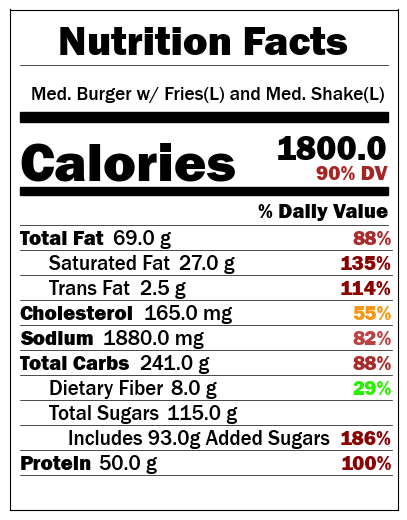

In [215]:
# Median Large Shake
cond = (mcdonalds.category == "Sweets & Treats") & (mcdonalds.product_name.str.endswith("Shake")) & (mcdonalds["size"] == "Large")
large_shake = np.round(mcdonalds.loc[cond, "calories":"protein"].median().values, 2)

# add median fries and median large shake to median burger
category = "Burgers"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += large_fries + large_shake

# Create nutrition label
median_values = round(df.median(), 2).values
title = "Burger w/ Fries(L) and Med. Shake(L)"
create_nutritional_label(np.array(list(limits.values())), median_values, title, 14)

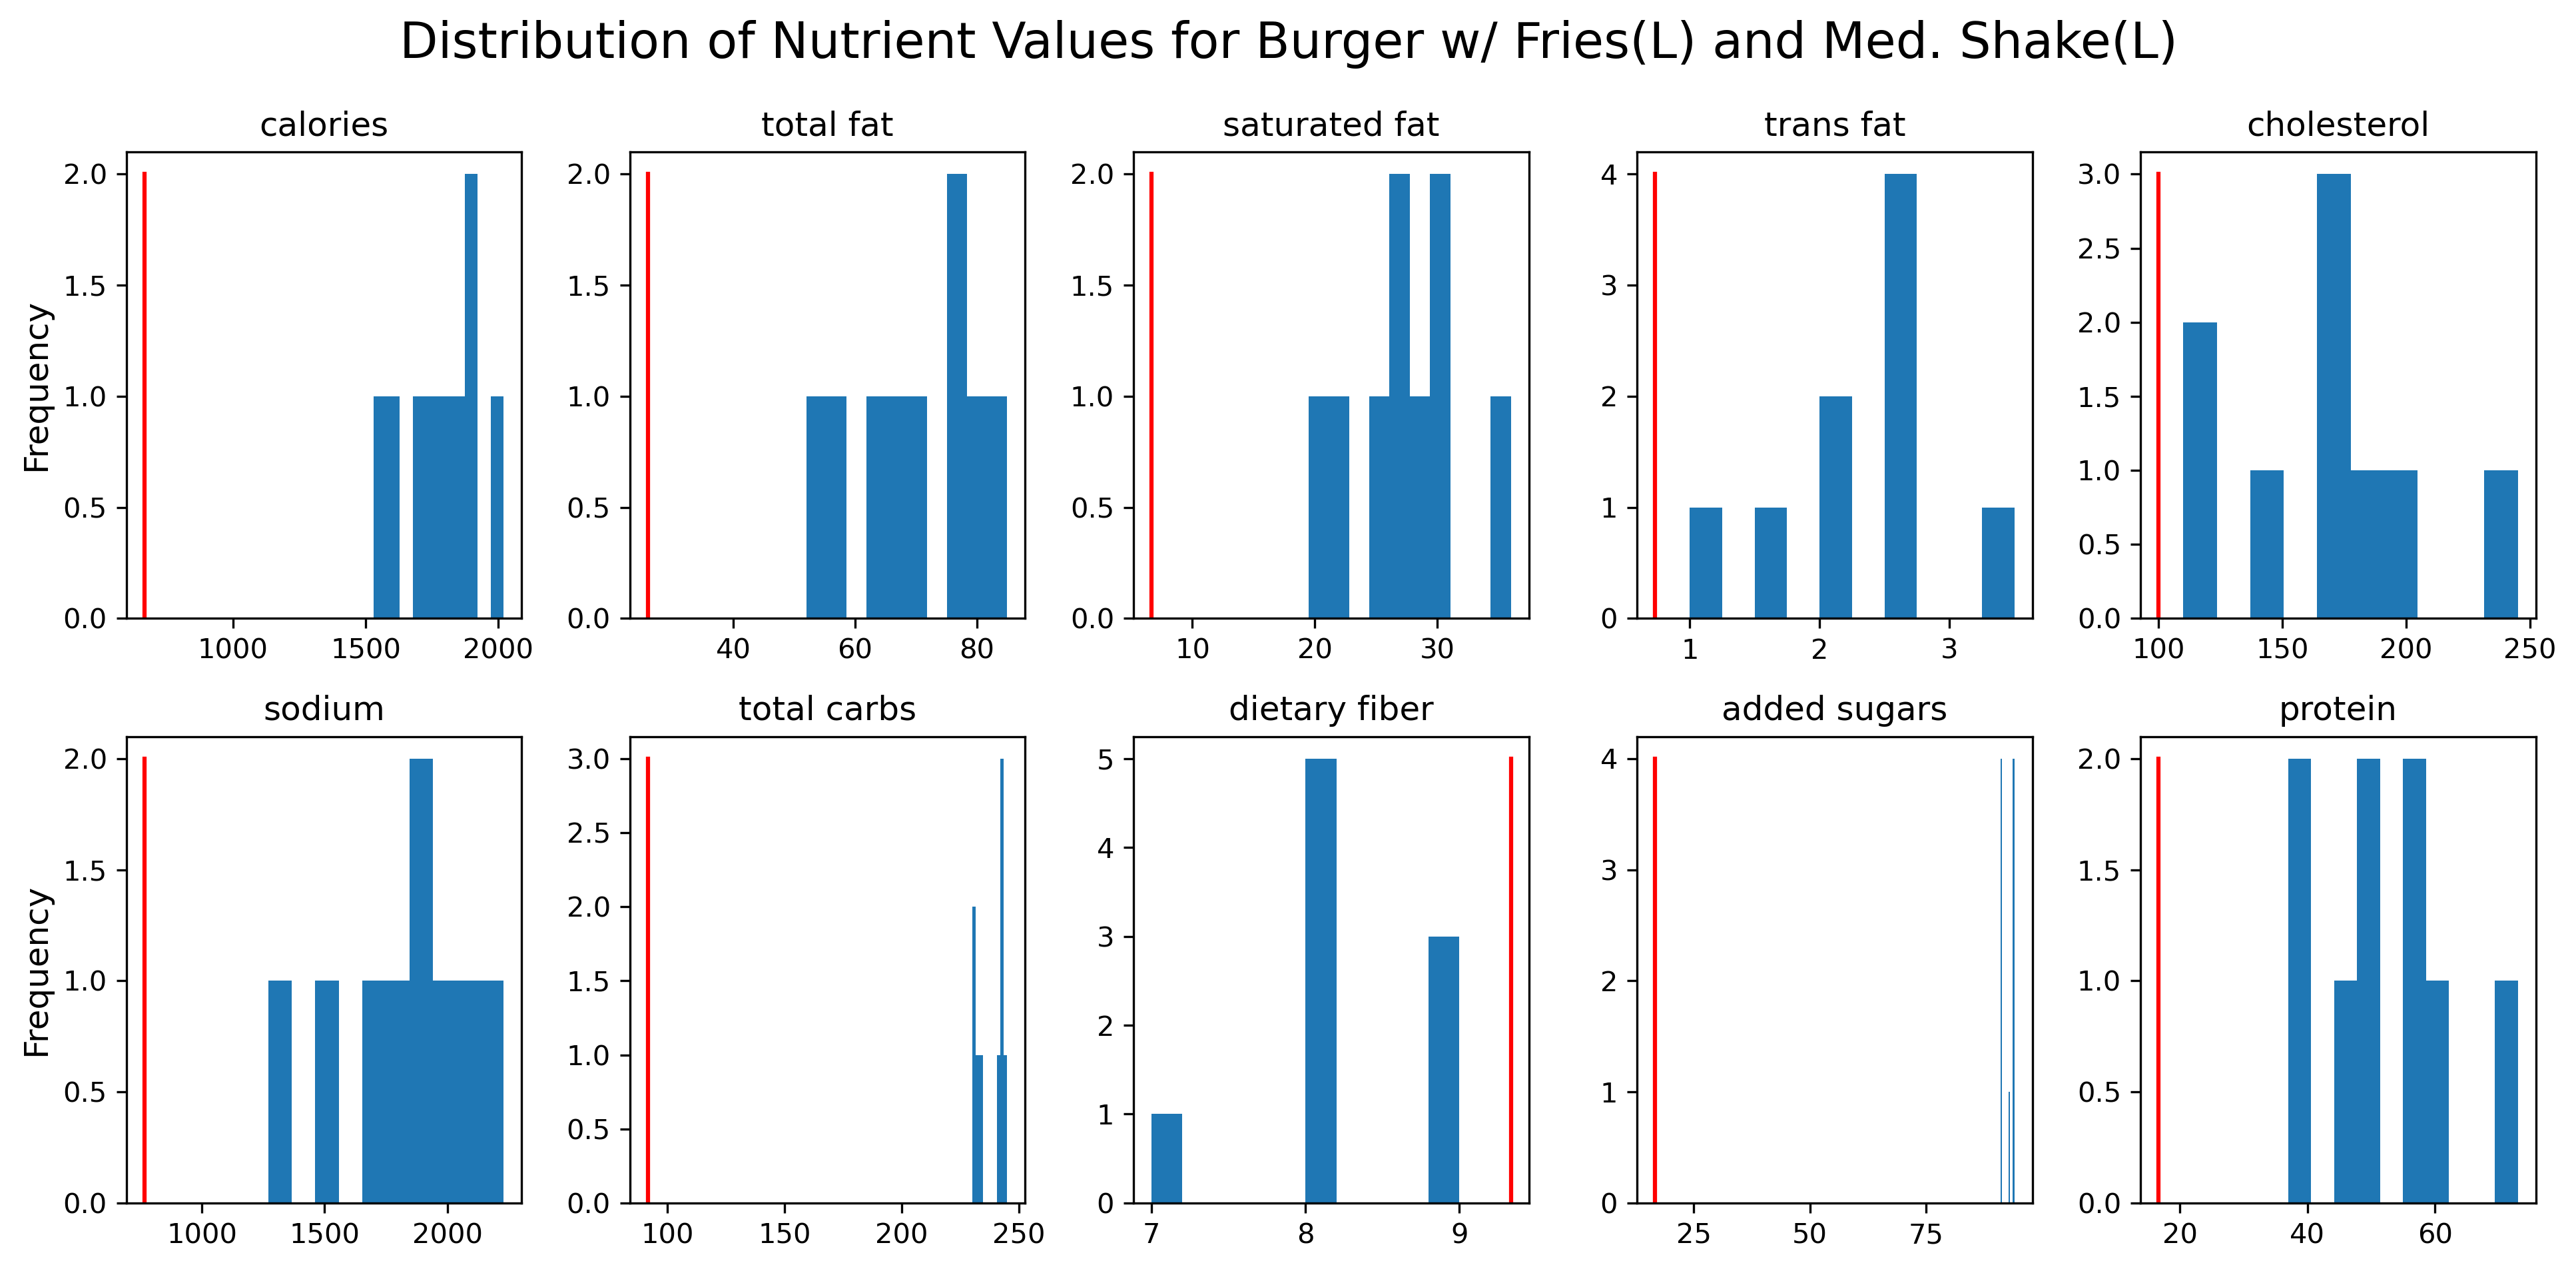

In [216]:
show_distribution(category, title, df)

## Chicken & Fish Sandwiches and McNuggets

### Chicken & Fish Sandwiches

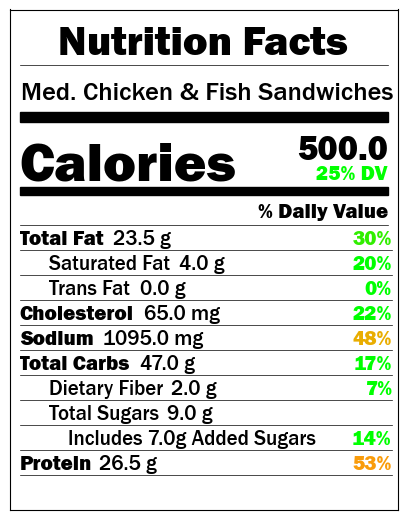

In [217]:
category = "Chicken & Fish Sandwiches"
quick_label(category, 19)

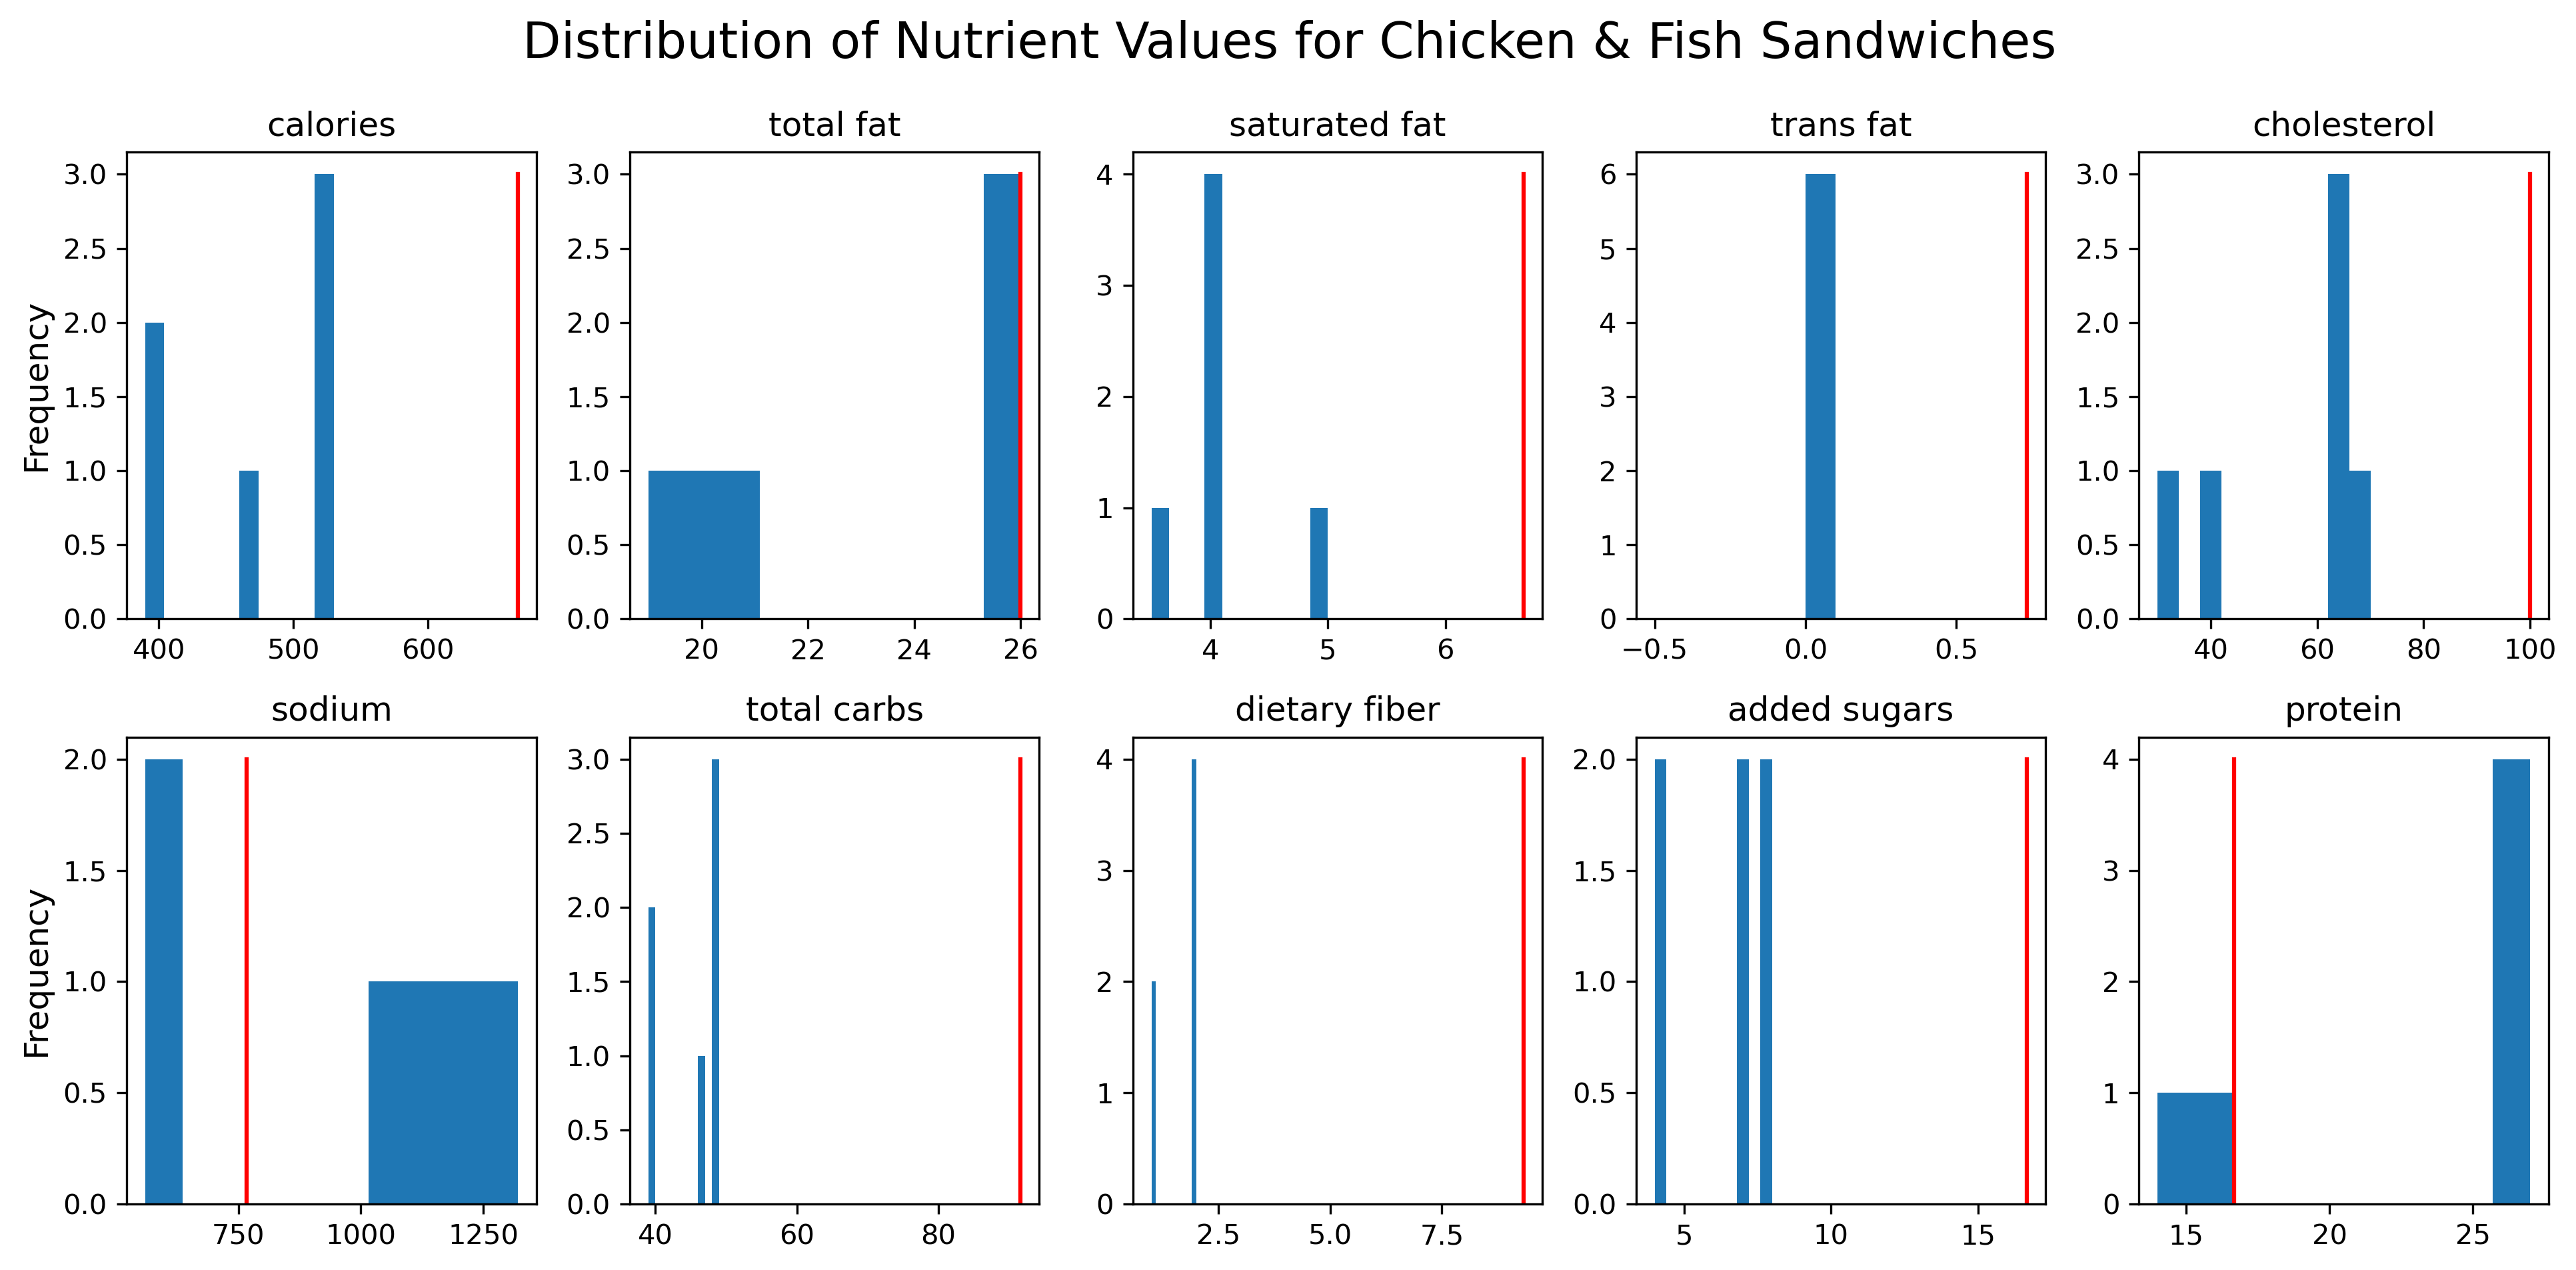

In [218]:
show_distribution(category, category)

### McNuggets and Meals

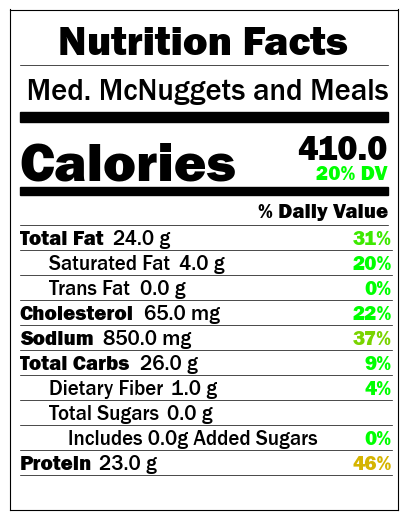

In [219]:
category = "McNuggets and Meals"
quick_label(category)

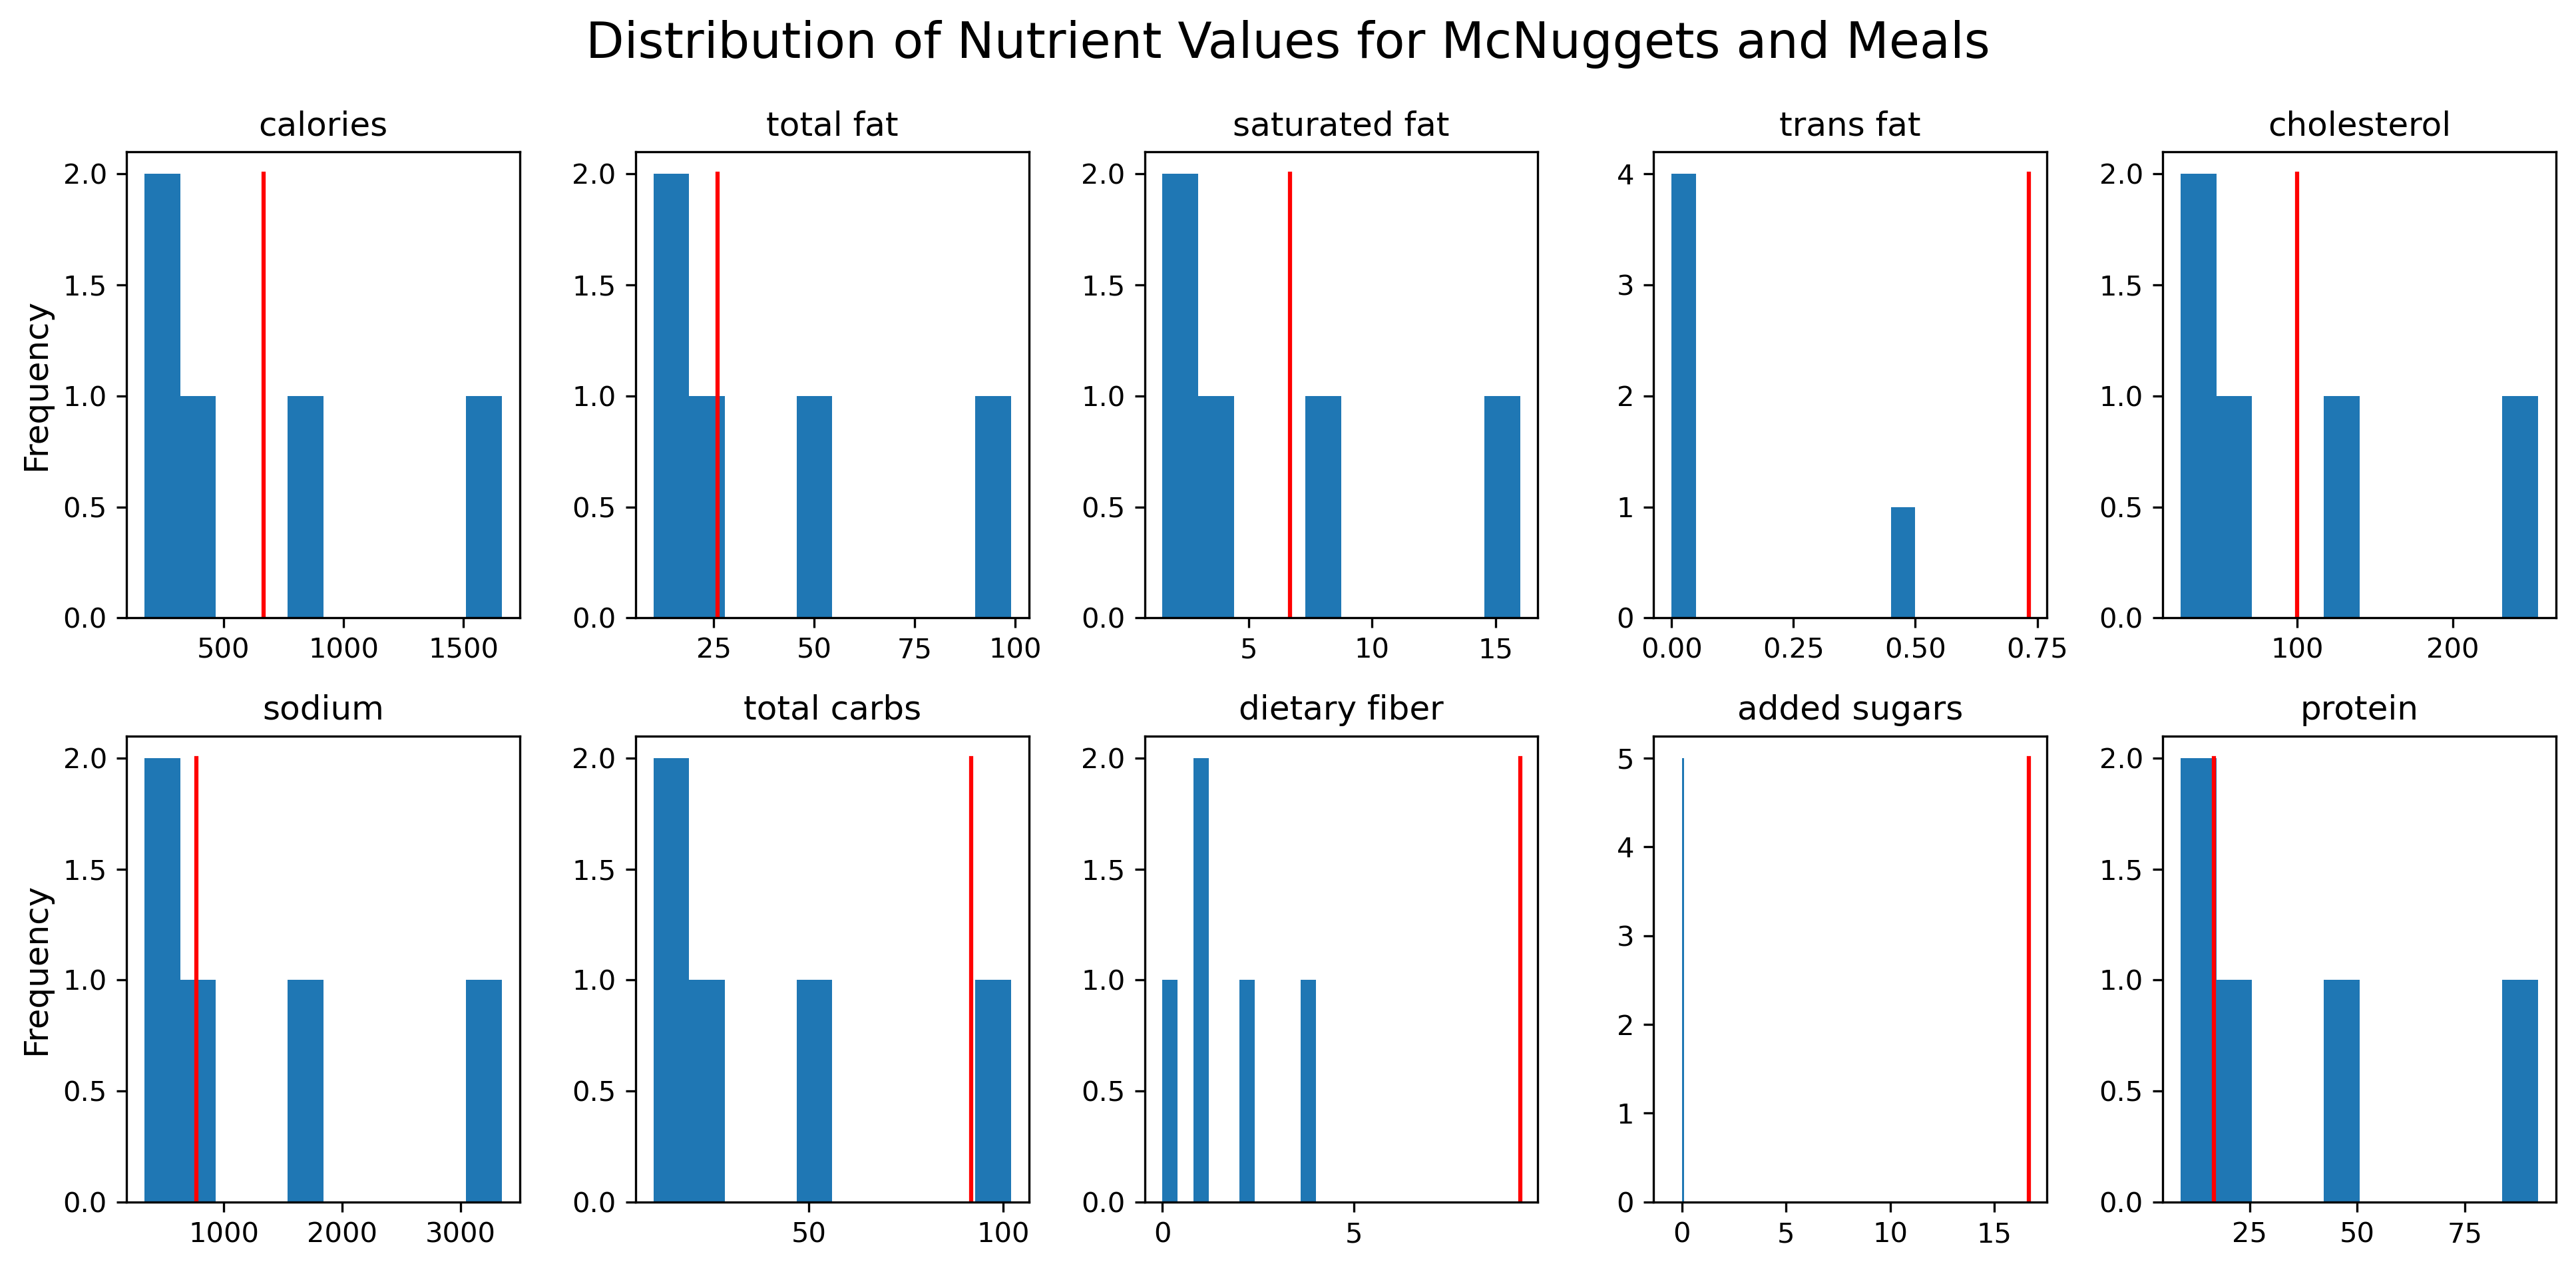

In [220]:
show_distribution(category, category)

### Median Chicken & Fish + Small Fries + Median Small Beverage

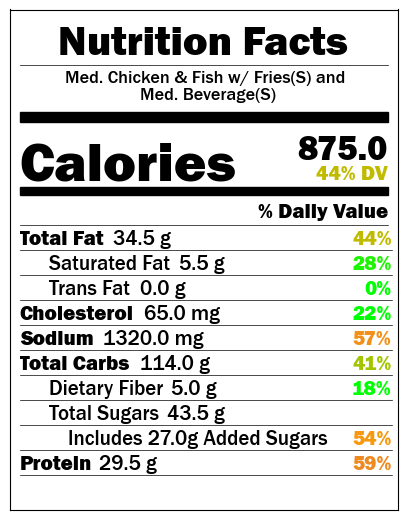

In [221]:
# Add the values of a small fry and median small beverage to the df
category = "Chicken & Fish Sandwiches"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += small_fries + small_drink

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "Chicken & Fish w/ Fries(S) and \nMed. Beverage(S)"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 13)

### Median McNuggets and Meals + Small Fries + Median Small Beverage

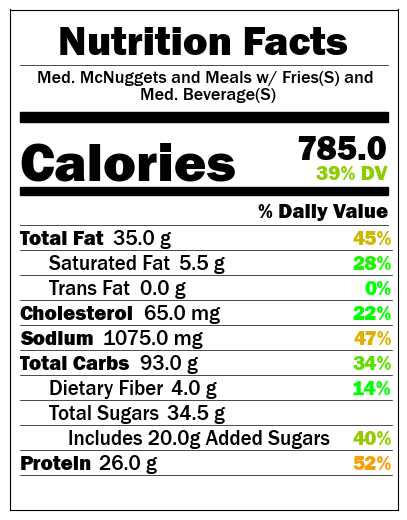

In [222]:
# Add the values of a small fry and median small beverage to the df
category = "McNuggets and Meals"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += small_fries + small_drink

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "McNuggets and Meals w/ Fries(S) and \nMed. Beverage(S)"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 13)

### Median Chicken & Fish + Small Fries + Median Small Shake

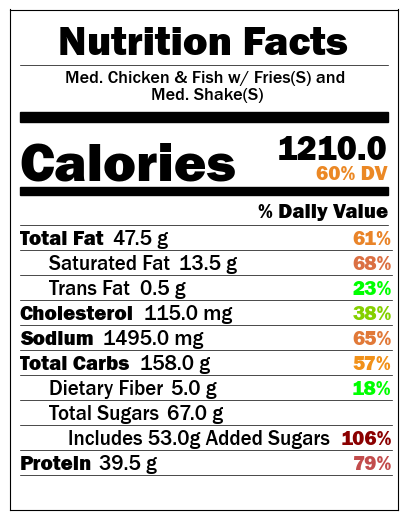

In [223]:
# Add the values of a small fry and median small beverage to the df
category = "Chicken & Fish Sandwiches"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += small_fries + small_shake

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "Chicken & Fish w/ Fries(S) and \nMed. Shake(S)"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 13)

### Median McNuggets and Meals + Small Fries + Median Small Shake

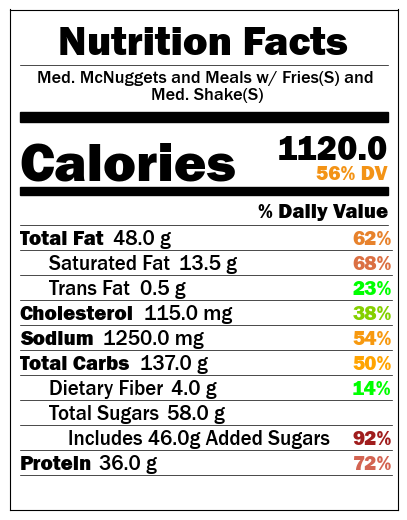

In [224]:
# Add the values of a small fry and median small beverage to the df
category = "McNuggets and Meals"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += small_fries + small_shake

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "McNuggets and Meals w/ Fries(S) and \nMed. Shake(S)"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 13, save = True)

## Sweets & Treats

### Sweets & Treats

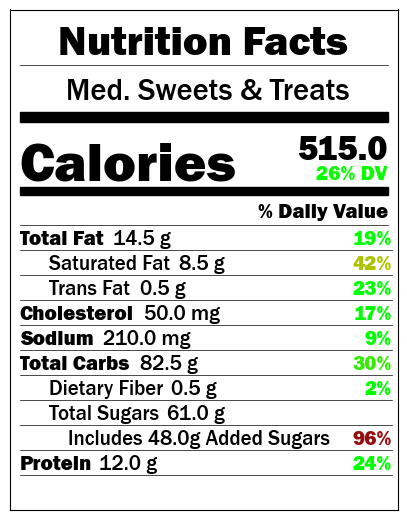

In [225]:
category = "Sweets & Treats"
quick_label(category)

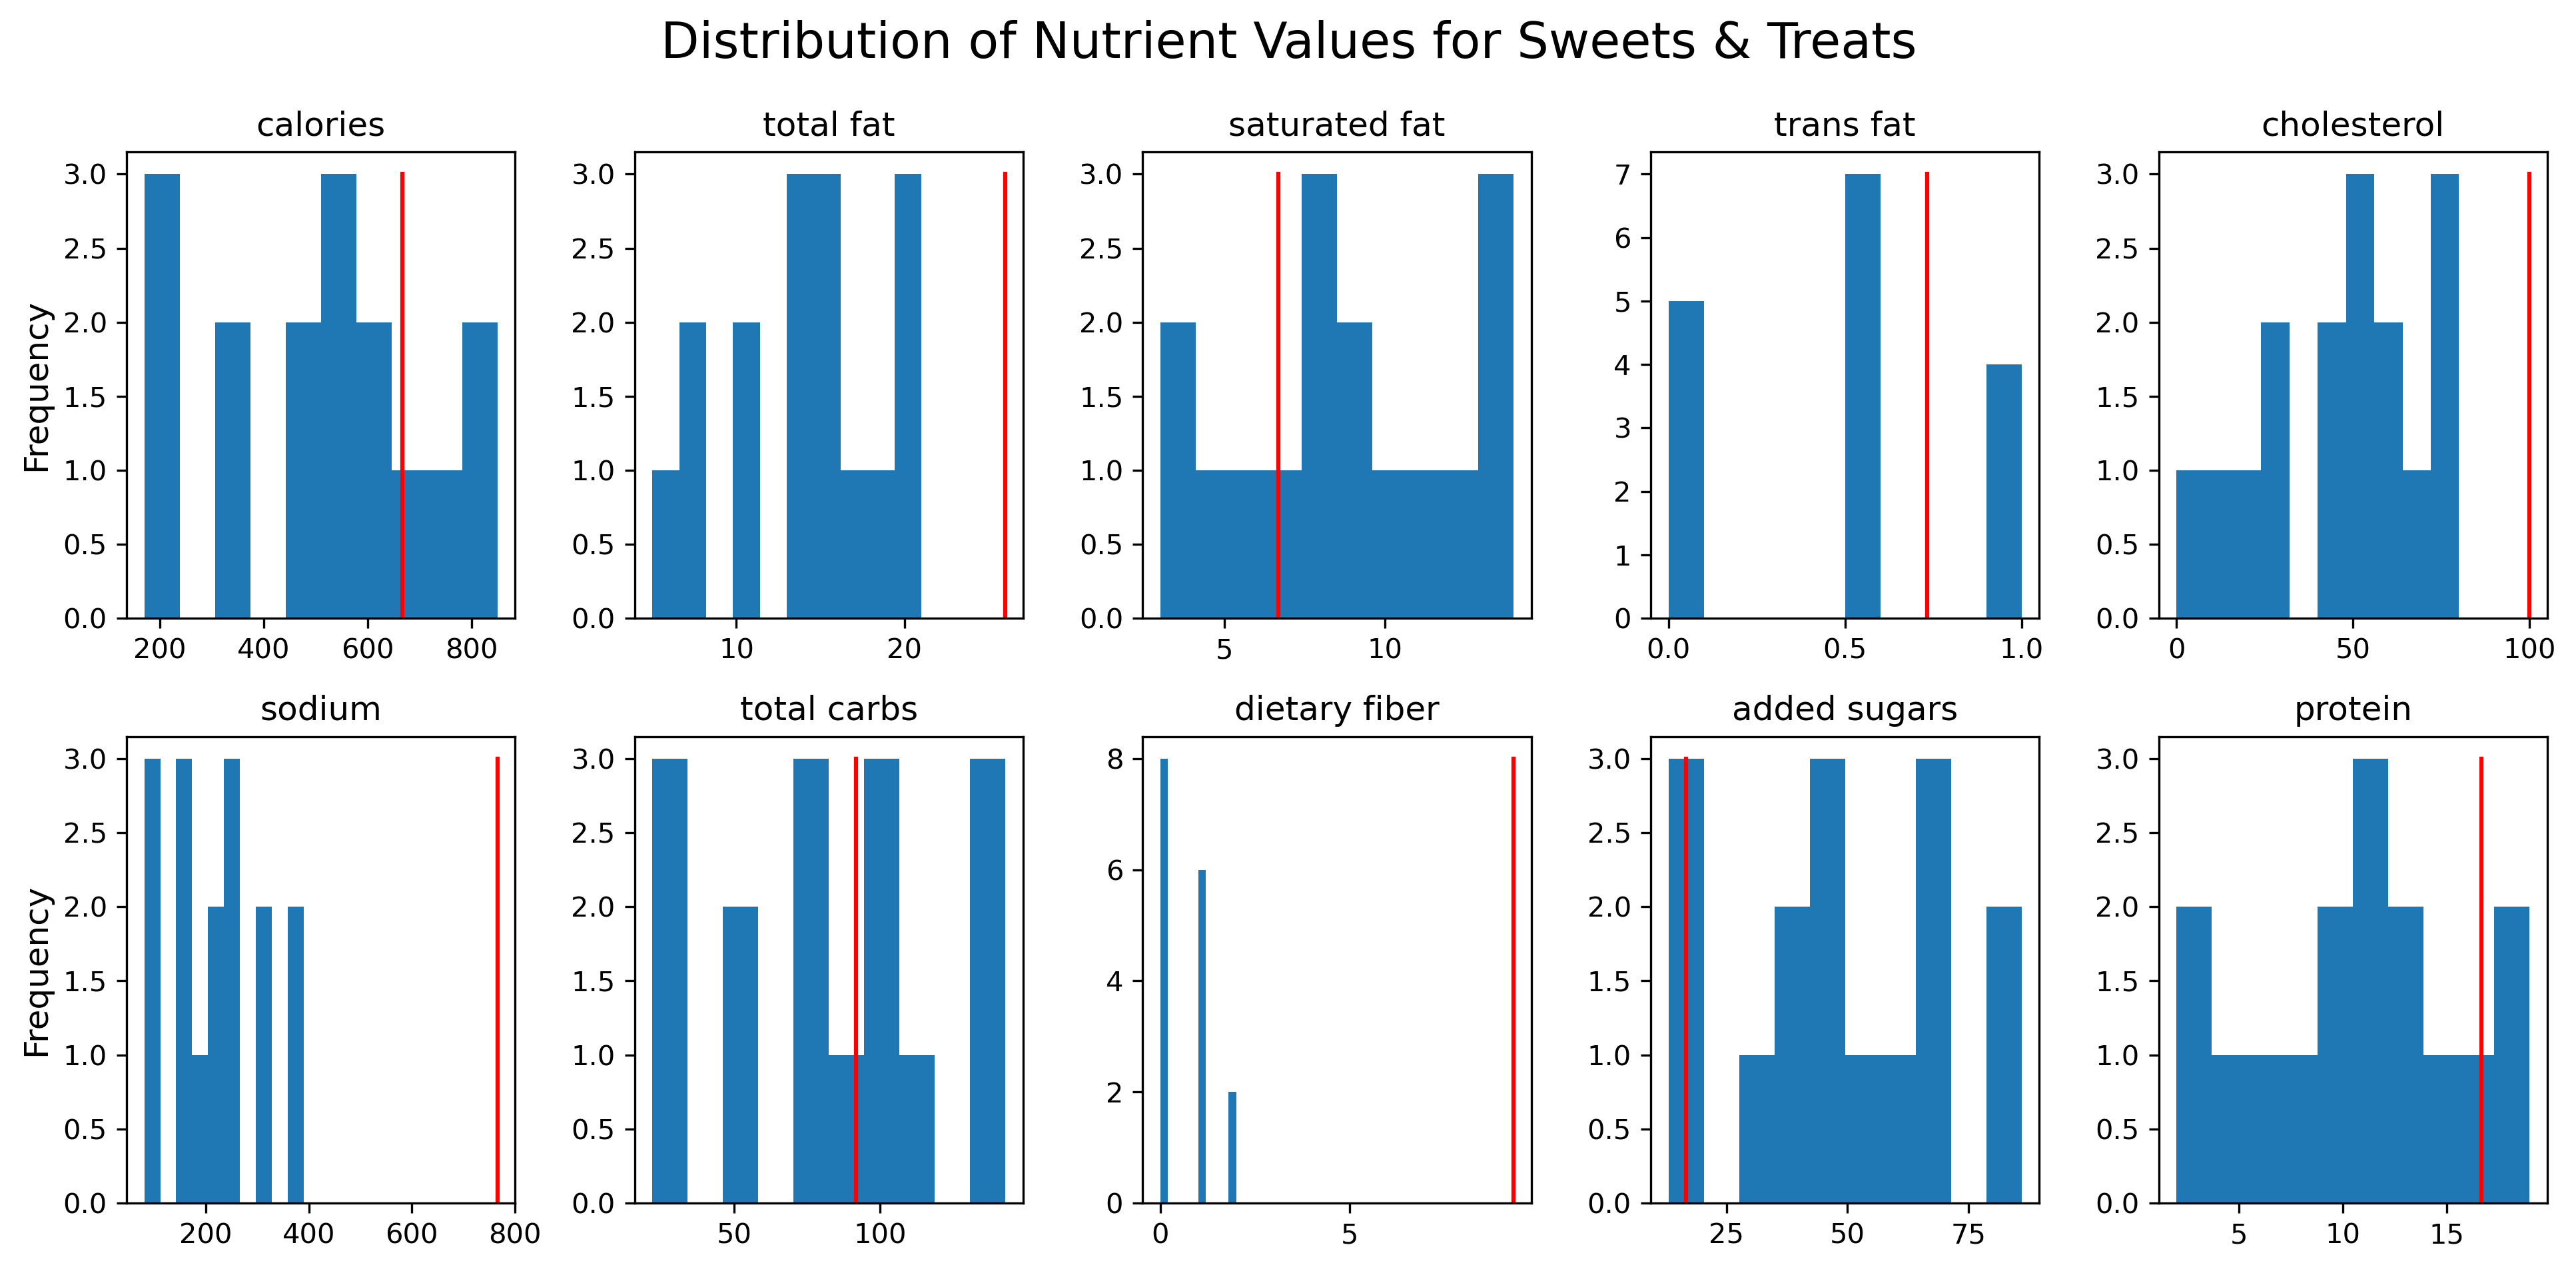

In [226]:
show_distribution(category, category)

### Median Burgers +  Median Sweets & Treats

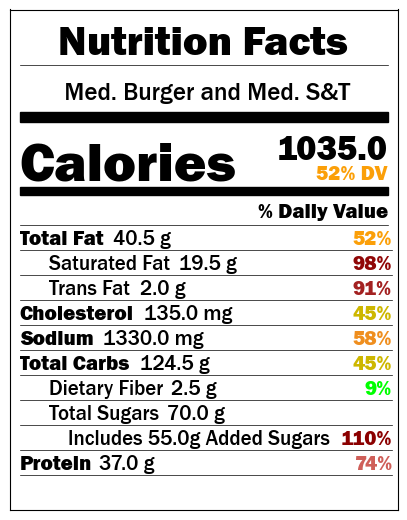

In [227]:
# Median Sweets & Treats
cond = (mcdonalds.category == "Sweets & Treats") 
dessert = np.round(mcdonalds.loc[cond, "calories":"protein"].median().values, 2)

# Add small fry and median sweets & Treats values to df
category = "Burgers"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += dessert

# Create nutritional label
median_values = round(df.median(), 2).values
title = "Burger and Med. S&T"
create_nutritional_label(np.array(list(limits.values())), median_values, title, 18)

### Median Chicken & Fish Sandwiches + Median Sweets & Treats

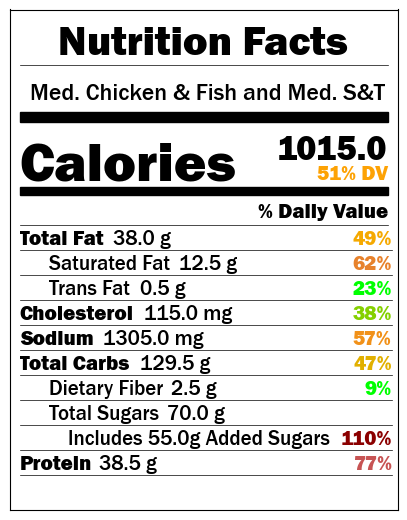

In [228]:
# Add the values of a small fry and median small beverage to the df
category = "Chicken & Fish Sandwiches"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += dessert

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "Chicken & Fish and Med. S&T"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 17)

### Median McNuggets + Median Sweets & Treats

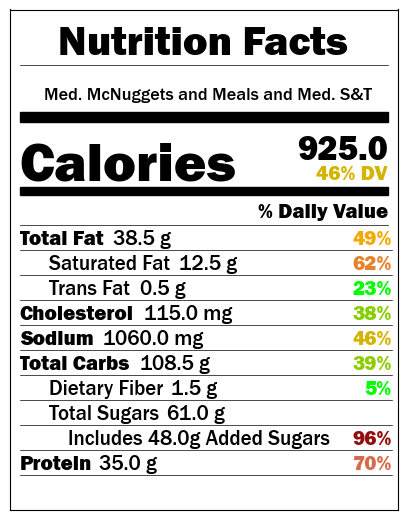

In [229]:
# Add the values of a small fry and median small beverage to the df
category = "McNuggets and Meals"
df = mcdonalds.loc[ mcdonalds.category == category, "calories":"protein"].copy()
df += dessert

# Create the nutritional label
median_values = round(df.median(), 2).values
title = "McNuggets and Meals and Med. S&T"
create_nutritional_label(np.array(list(limits.values())), median_values, title , 13, save = True)

## McCafe Coffees

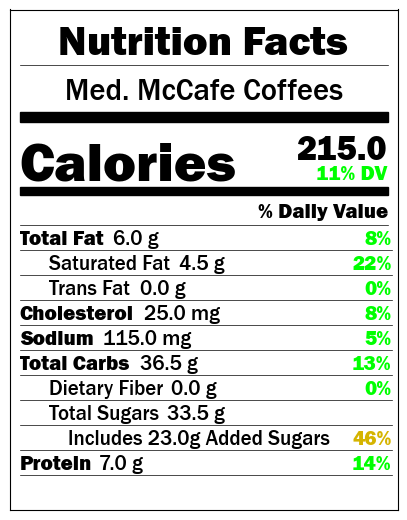

In [230]:
category = "McCafe Coffees"
quick_label(category)

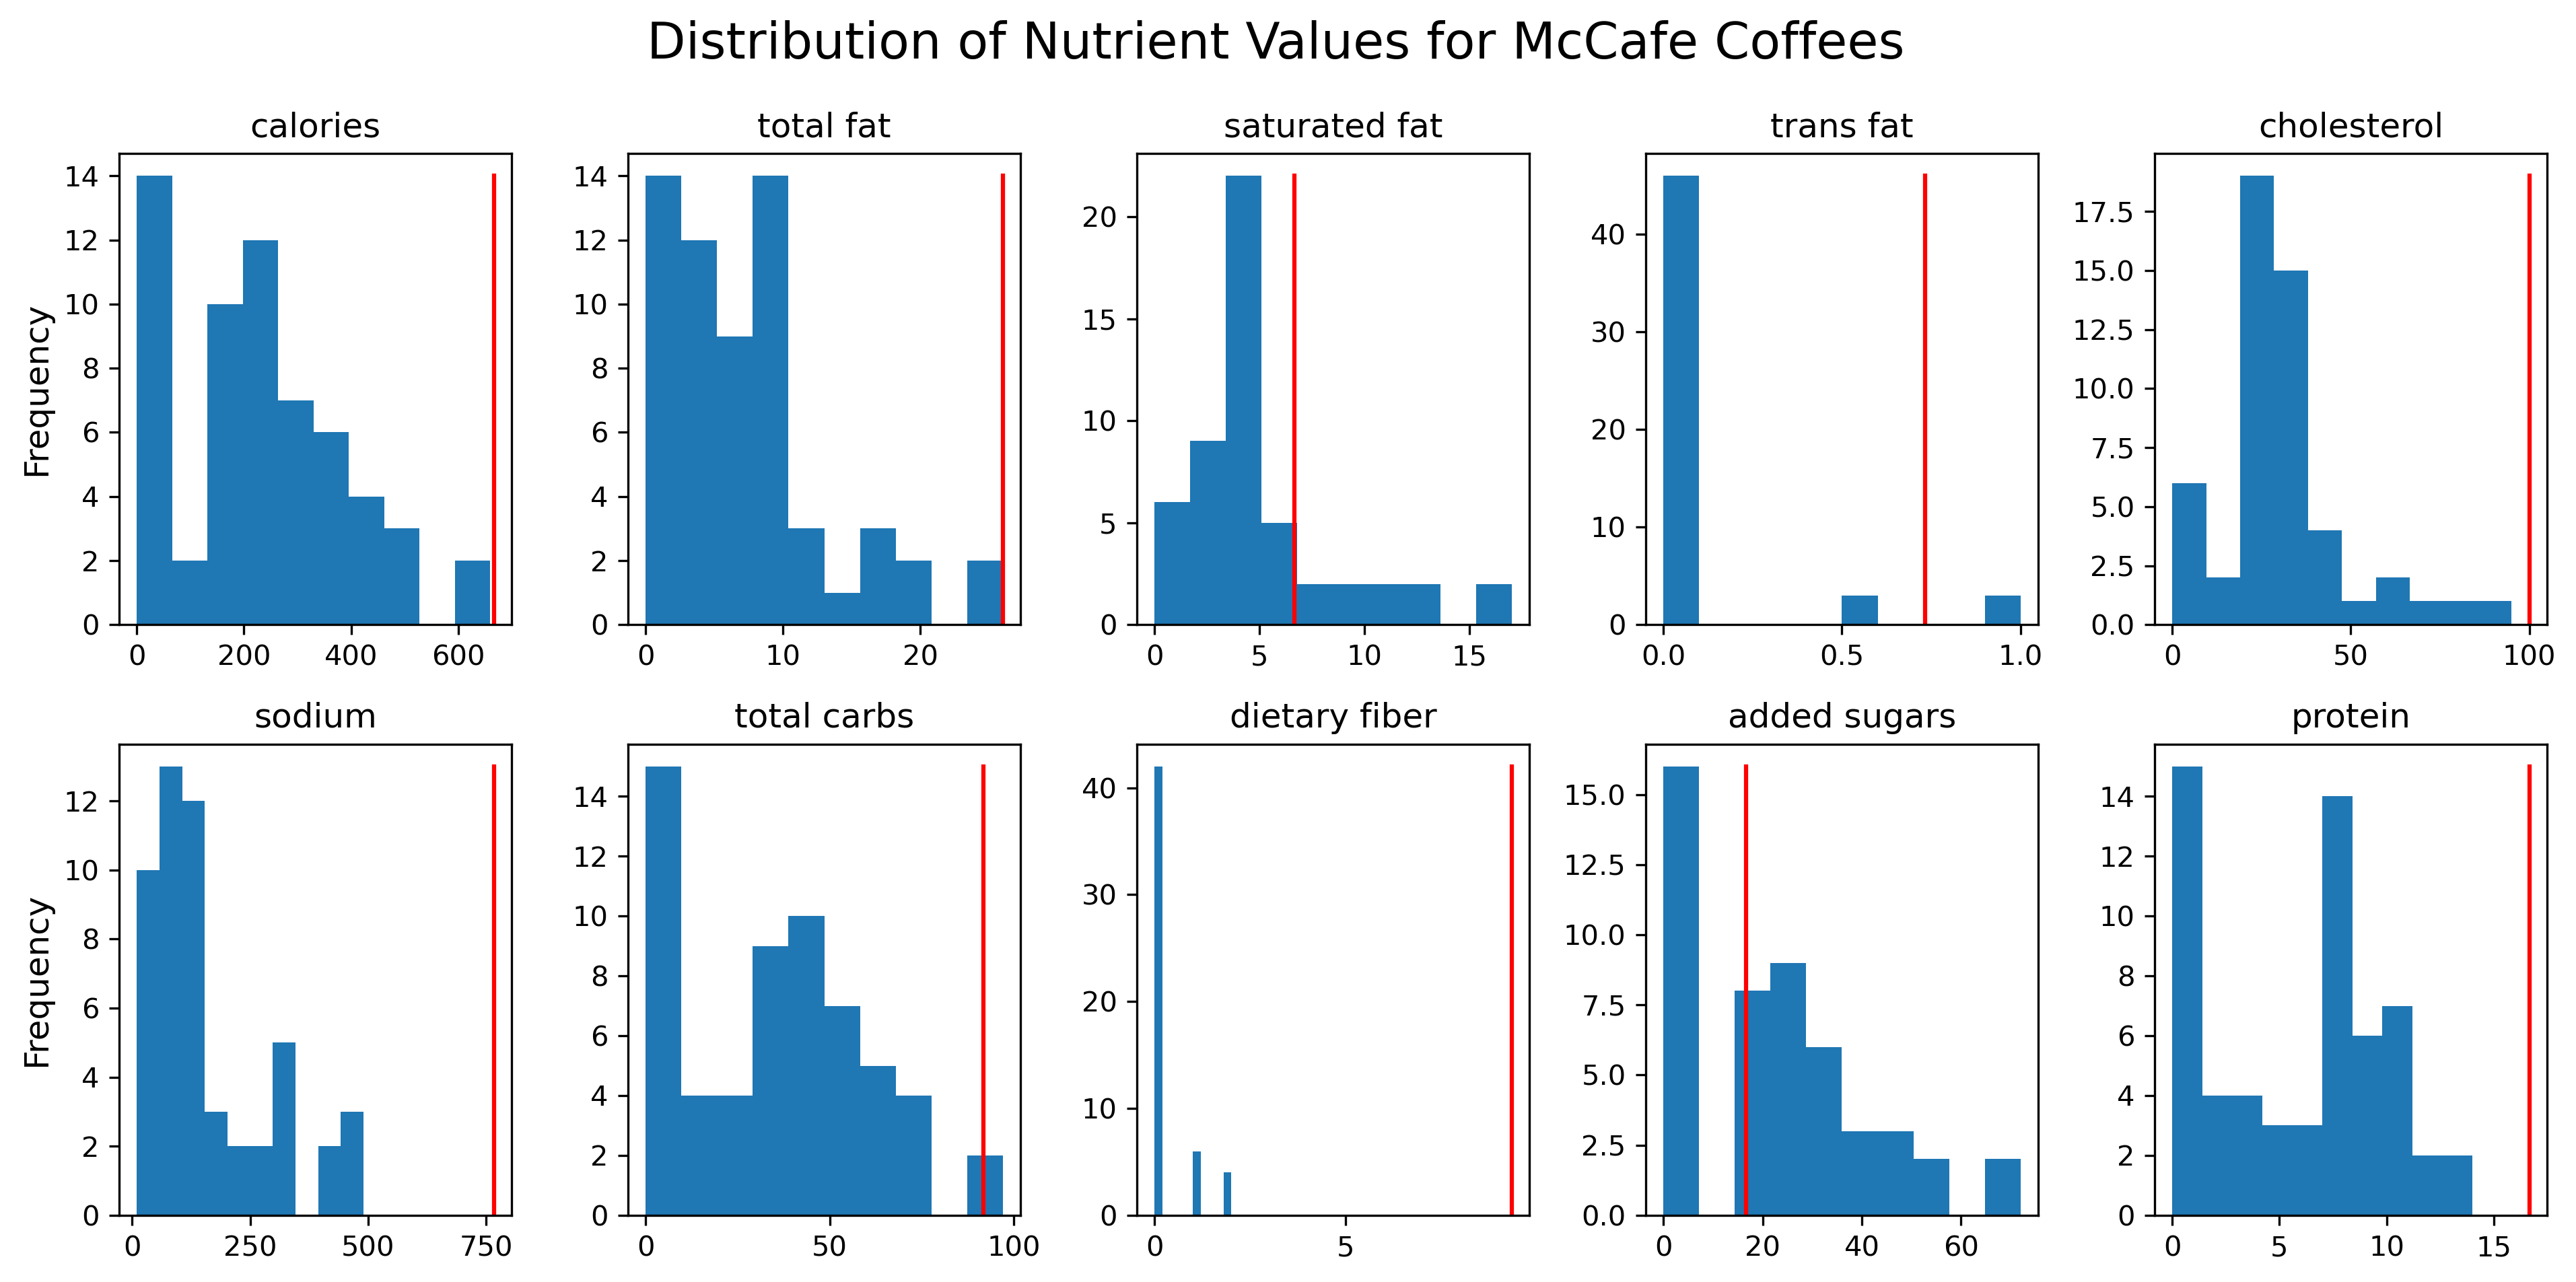

In [231]:
show_distribution(category, category, save = True)

## Beverages

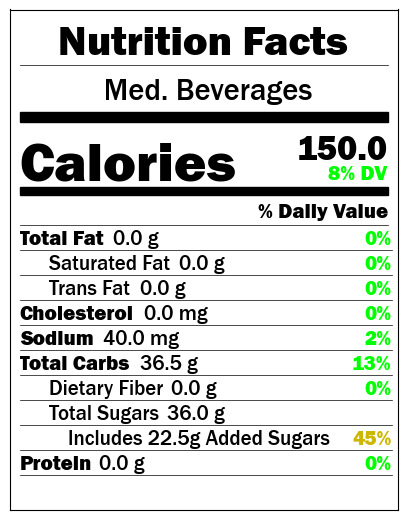

In [232]:
category = "Beverages"
quick_label(category)

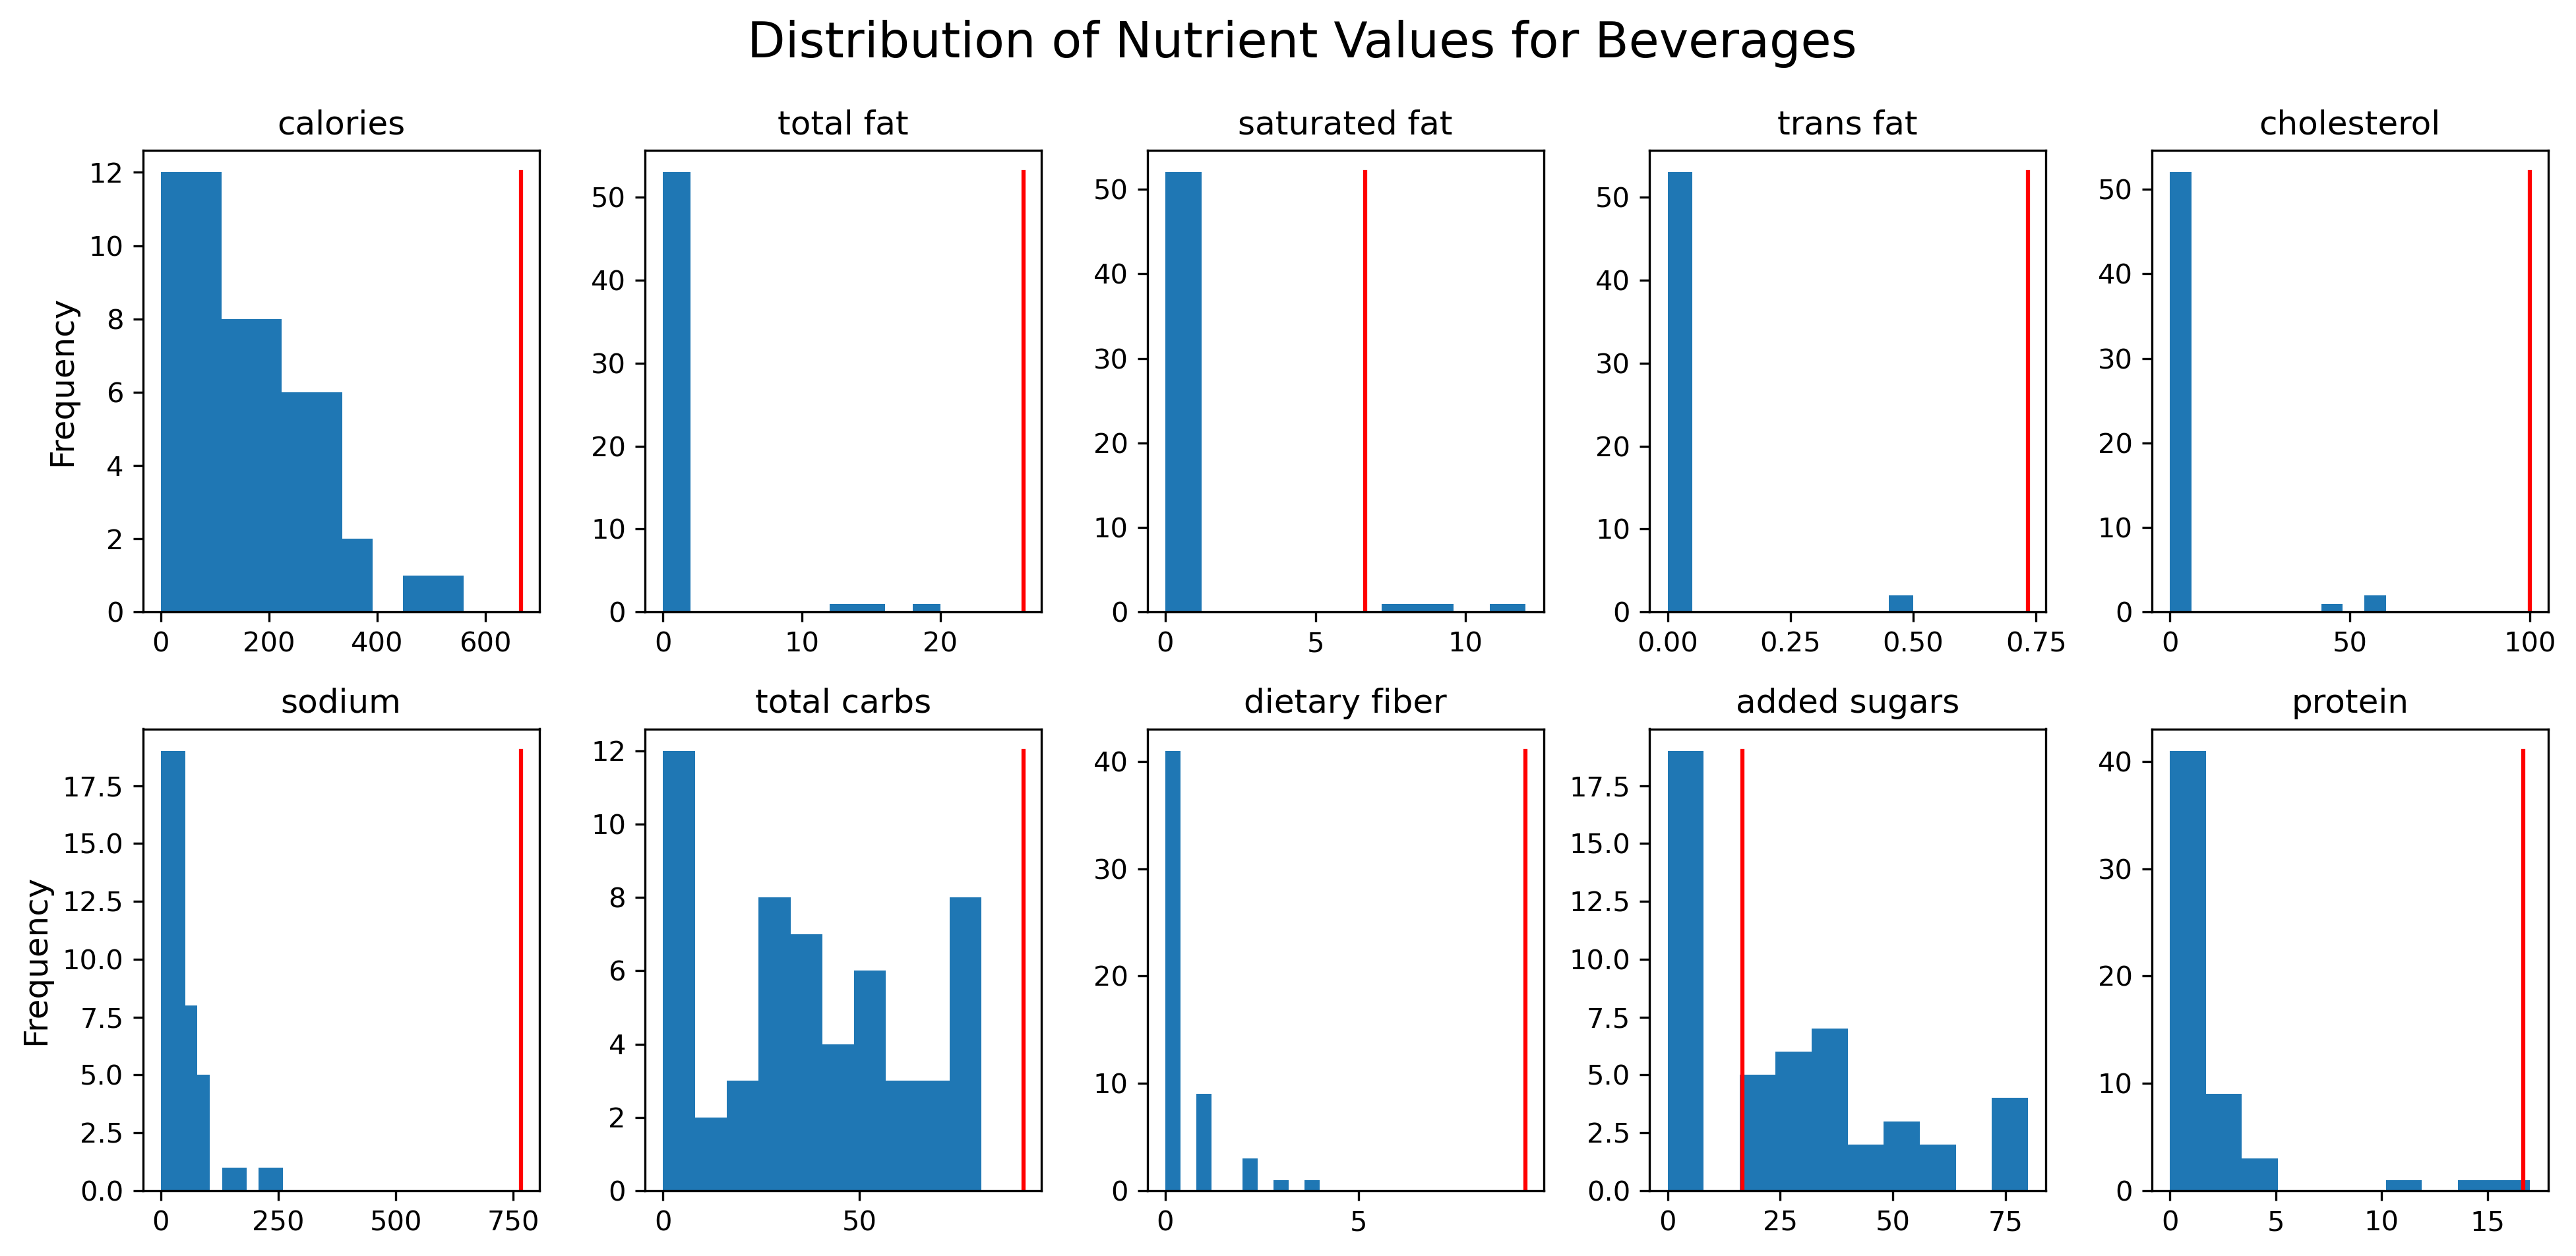

In [233]:
show_distribution(category, category)

## Fries & Sides

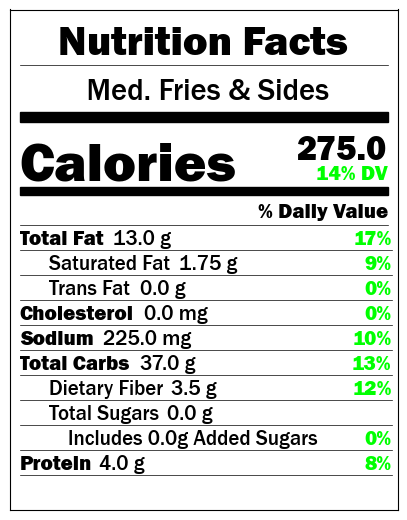

In [234]:
category = "Fries & Sides"
quick_label(category)

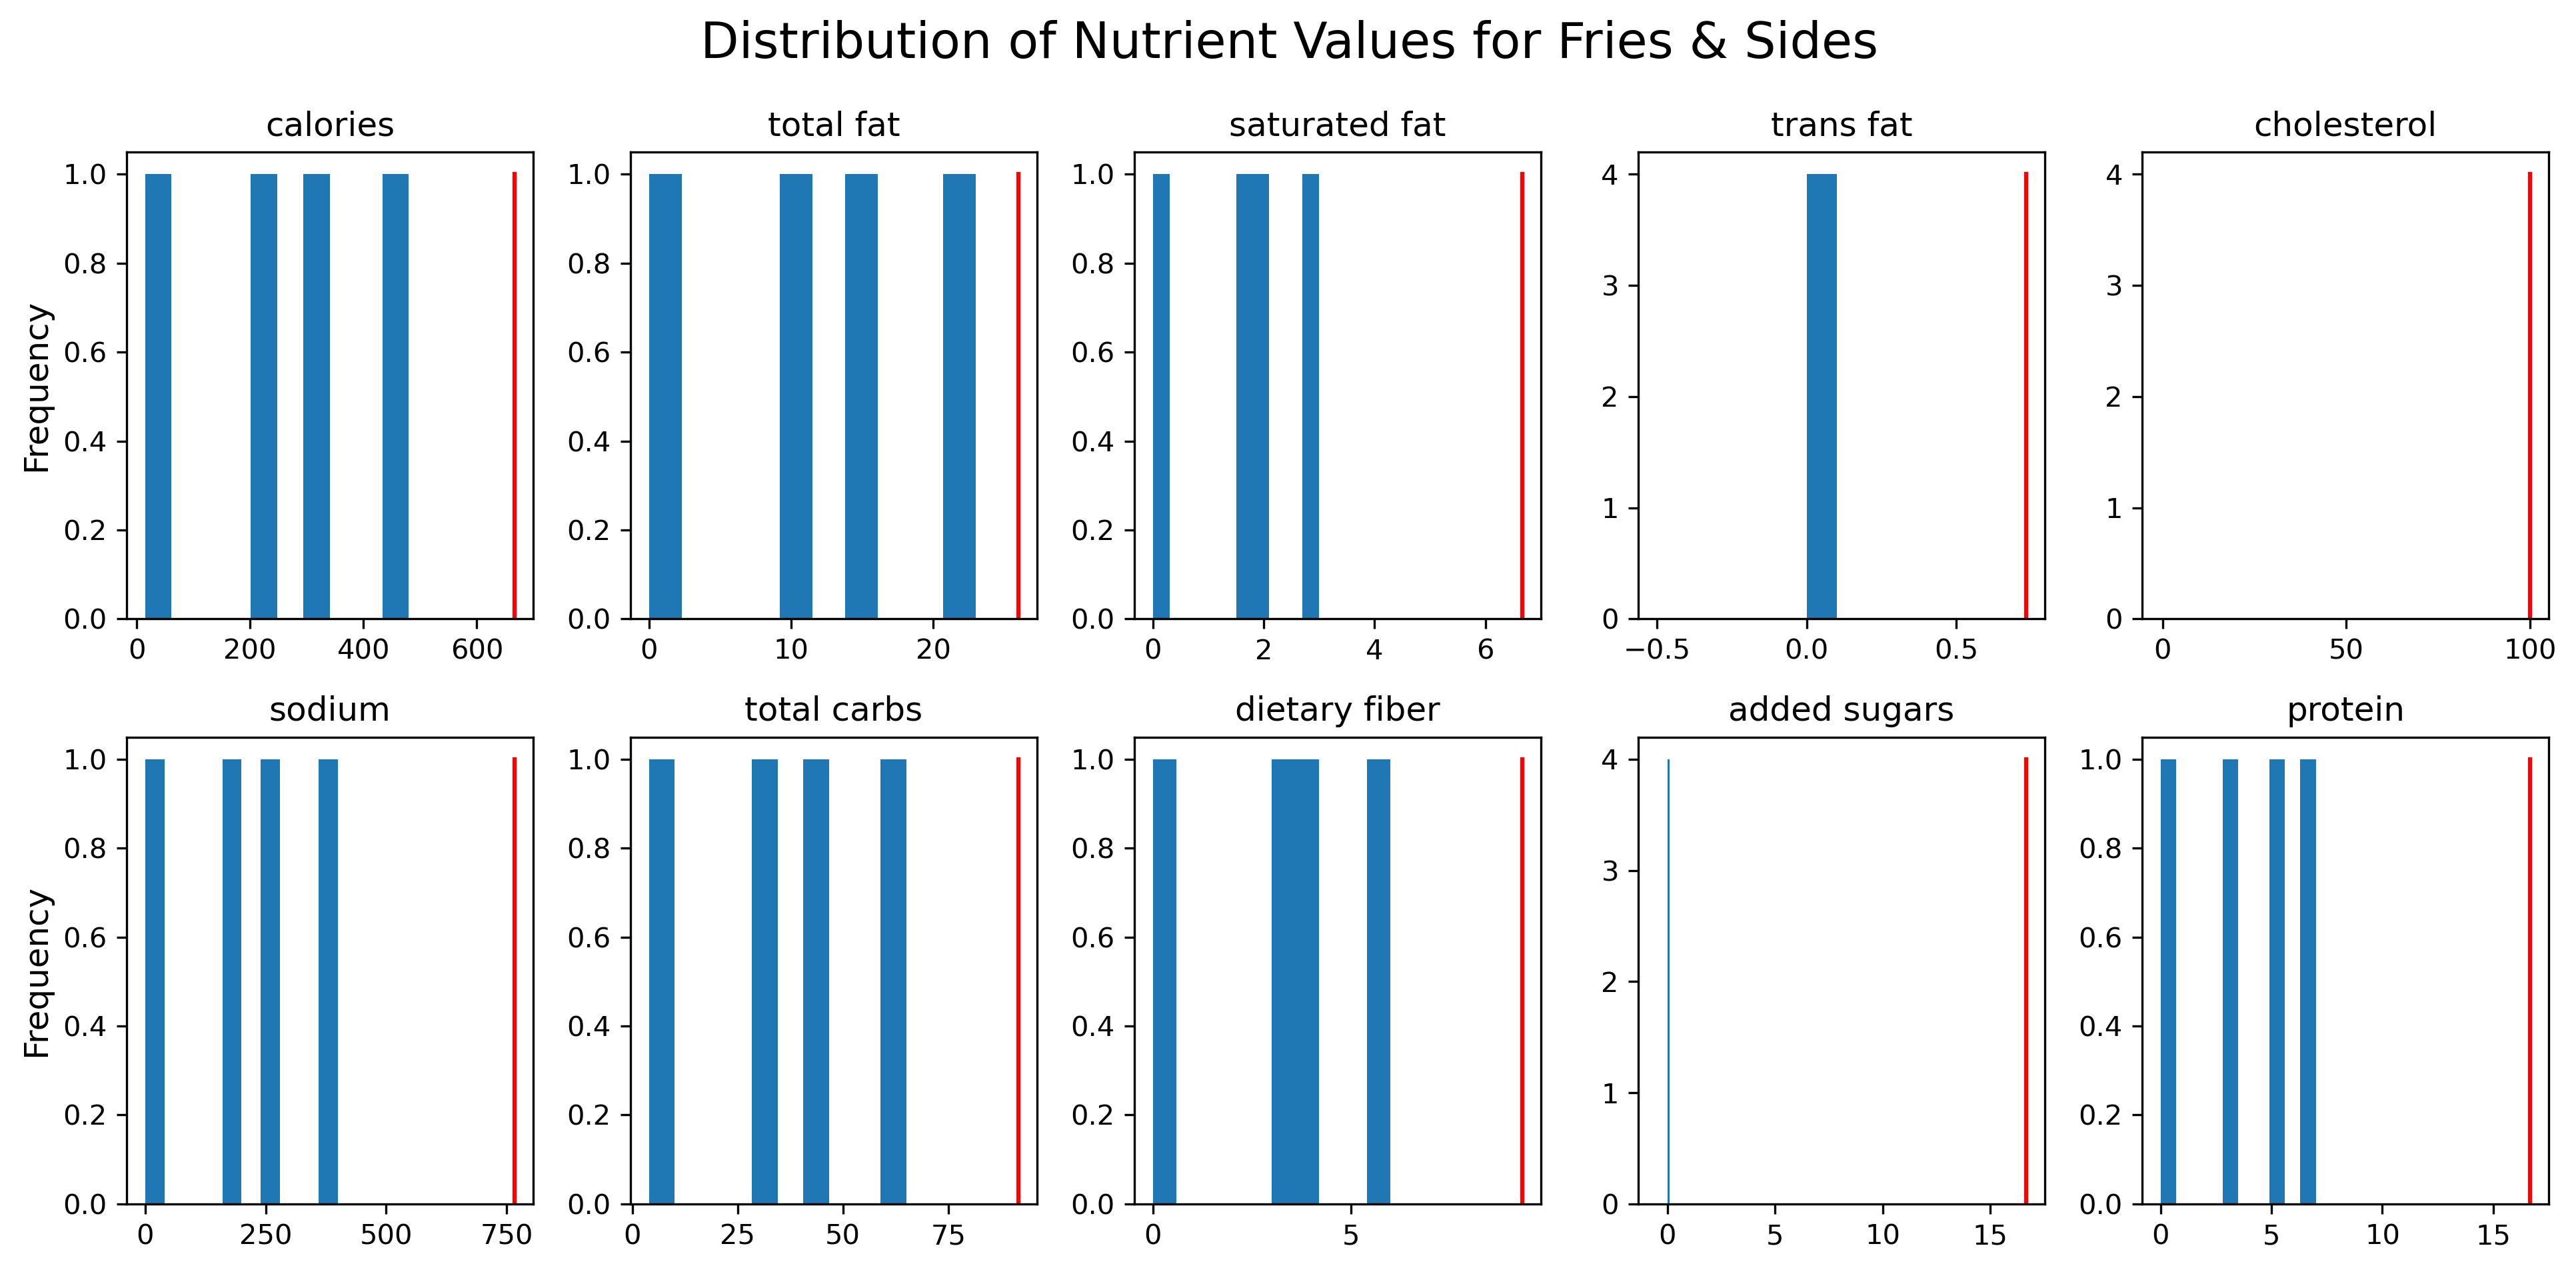

In [235]:
show_distribution(category, category)